# Analyze with Logit Lens

In [1]:
import os
import torch
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
torch.cuda.device_count()

4

In [2]:
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM
import re
import random
import torch
from dataclasses import dataclass
from typing import Tuple, List, Dict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

from metric_utils import em_for_interpretability

/home/hjh/.conda/envs/xai_final_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset & Model

In [3]:
# Load dataset
DATASET_PATH = "../../data/nq-swap-filtered"
dataset = load_from_disk(DATASET_PATH)
dataset[0] # check the first sample

{'question': 'how many episodes are in chicago fire season 4',
 'org_context': ' The fourth season of Chicago Fire , an American drama television series with executive producer Dick Wolf , and producers Derek Haas , Michael Brandt , and Matt Olmstead , was ordered on February 5 , 2015 , by NBC , and premiered on October 13 , 2015 and concluded on May 17 , 2016 . The season contained 23 episodes . ',
 'org_answer': ['23'],
 'sub_context': ' The fourth season of Chicago Fire , an American drama television series with executive producer Dick Wolf , and producers Derek Haas , Michael Brandt , and Matt Olmstead , was ordered on February 5 , 2015 , by NBC , and premiered on October 13 , 2015 and concluded on May 17 , 2016 . The season contained 775 episodes . ',
 'sub_answer': ['775']}

In [4]:
# Load model and tokenizer
MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype="auto")
# print model structure
model.eval()
model

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [5]:
# Preprocess input
def preprocess_function(examples):
    pattern = r"</?[a-zA-Z0-9_]+>"  # remove HTML tags
    targets = ["org_context", "sub_context"]
    
    for col in targets:
        examples[col] = [re.sub(pattern, "", text) for text in examples[col]]
    return examples

In [6]:
dataset = dataset.map(preprocess_function, batched=True)
dataset[0]

{'question': 'how many episodes are in chicago fire season 4',
 'org_context': ' The fourth season of Chicago Fire , an American drama television series with executive producer Dick Wolf , and producers Derek Haas , Michael Brandt , and Matt Olmstead , was ordered on February 5 , 2015 , by NBC , and premiered on October 13 , 2015 and concluded on May 17 , 2016 . The season contained 23 episodes . ',
 'org_answer': ['23'],
 'sub_context': ' The fourth season of Chicago Fire , an American drama television series with executive producer Dick Wolf , and producers Derek Haas , Michael Brandt , and Matt Olmstead , was ordered on February 5 , 2015 , by NBC , and premiered on October 13 , 2015 and concluded on May 17 , 2016 . The season contained 775 episodes . ',
 'sub_answer': ['775']}

## Create Logit Lens Inputs

In [7]:
# Set target samples
def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# SAMPLE_NUMS = 50
# samples = random.sample(range(len(dataset)), SAMPLE_NUMS)
# print(samples)
samples = list(range(len(dataset))) # use all samples

In [8]:
# base template for user input
PURE_USER_TEMPLATE = "Question: {question}\n\n"
RAG_USER_TEMPLATE = "Context: {context}\n\nQuestion: {question}\n\n"

# Model generation kwargs
MODEL_KWARGS = {
    "return_dict_in_generate": True,
    "max_new_tokens": 32,
    "do_sample": False,
    "top_p": 1.0,
    "pad_token_id": tokenizer.eos_token_id
}
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.pad_token_id = model.config.eos_token_id

In [9]:
# Define dataclass for Logit Lens inputs
@dataclass
class LogitLensInputs:
    input_len: int
    hidden_states: torch.Tensor # (Layers, Batch, Seq, Dim)
    generated_ids: torch.Tensor # (Batch, Gen_Len)
    output_text: str

In [10]:
def move_to_cpu(output):
    """
    ModelOutput 객체 내부의 텐서들을 CPU로 이동시키는 헬퍼 함수
    """
    if hasattr(output, "sequences"):
        output.sequences = output.sequences.cpu()
    
    if hasattr(output, "hidden_states") and output.hidden_states:
        n_layers = len(output.hidden_states)

        stacked_layers = []
        for layer_idx in range(n_layers):
            stacked_layers.append(output.hidden_states[layer_idx].cpu())

        output.hidden_states = torch.stack(stacked_layers, dim=0)

def _generate_and_pack(
    model,
    tokenizer,
    context: str,
    question: str,
    answers: list[str],
    input_type: str
) -> LogitLensInputs:
    if input_type == "original":
        user_content = PURE_USER_TEMPLATE.format(
            question=question
        )
    else:
        user_content = RAG_USER_TEMPLATE.format(
            context=context,
            question=question
        )
    
    messages = [
        {"role": "user", "content": user_content}
    ]
    input_ids = tokenizer.apply_chat_template(
        messages,
        return_tensors="pt",
        add_generation_prompt=True
    ).to(model.device)
    inputs = {
        "input_ids": input_ids,
        "attention_mask": torch.ones_like(input_ids).to(model.device)
    }
    # Generate text first to get generated ids
    with torch.no_grad():
        outputs = model.generate(**inputs, **MODEL_KWARGS)
    
    full_sequence_ids = outputs.sequences
    generated_ids = full_sequence_ids[:, len(input_ids[0]):]
    output_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    is_correct = em_for_interpretability(output_text, answers)

    # Perform forward pass again to get hidden states
    with torch.no_grad():
        forward_outputs = model(
            full_sequence_ids,
            output_hidden_states=True
        )

    move_to_cpu(forward_outputs)

    logit_lens_inputs = LogitLensInputs(
        input_len=input_ids.shape[1],
        hidden_states=forward_outputs.hidden_states,
        generated_ids=generated_ids.cpu(),
        output_text=output_text
    )
    return logit_lens_inputs, is_correct


def forward_samples(model, tokenizer, dataset, idx) -> Tuple[LogitLensInputs, LogitLensInputs, bool, bool]:
    question = dataset[idx]["question"]
    
    # Forward over a original context
    org_logit_lens_inputs, org_is_correct = _generate_and_pack(
        model,
        tokenizer,
        context=dataset[idx]["org_context"],
        question=question,
        answers=dataset[idx]["org_answer"],
        input_type="original"
    )

    # Forward over a substituted context
    sub_logit_lens_inputs, sub_is_correct = _generate_and_pack(
        model,
        tokenizer,
        context=dataset[idx]["sub_context"],
        question=question,
        answers=dataset[idx]["sub_answer"],
        input_type="substituted"
    )
    
    return org_logit_lens_inputs, sub_logit_lens_inputs, org_is_correct, sub_is_correct

In [11]:
# Sample test
test = samples[0]
org_logit_lens_inputs, sub_logit_lens_inputs, _, _ = forward_samples(model, tokenizer, dataset, test)
type(org_logit_lens_inputs), type(sub_logit_lens_inputs)

/home/hjh/.conda/envs/xai_final_project/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


(__main__.LogitLensInputs, __main__.LogitLensInputs)

In [31]:
# Forward all samples

all_logit_lens_inputs = []
for idx in tqdm(samples, desc="Forwarding samples"):
    org_logit_lens_inputs, sub_logit_lens_inputs, org_is_correct, sub_is_correct = forward_samples(
        model, tokenizer, dataset, idx)
    if not org_is_correct and not sub_is_correct:
        continue
    all_logit_lens_inputs.append({
        "idx": idx,
        "question": dataset[idx]["question"],
        "answer": dataset[idx]["org_answer"],
        "sub_answer": dataset[idx]["sub_answer"],
        "org_logit_lens_inputs": org_logit_lens_inputs,
        "sub_logit_lens_inputs": sub_logit_lens_inputs
    })

print(f"Total valid samples: {len(all_logit_lens_inputs)}")

Forwarding samples: 100%|██████████| 555/555 [19:38<00:00,  2.12s/it]

Total valid samples: 545


## Analyze

In [13]:
# Dummy space token id
SPACE_IDX = tokenizer.encode(" ", add_special_tokens=False)[0]

def get_first_divergent_token_offset(
    target_ids: List[int],
    counter_ids: List[int],
) -> Dict[str, int]:
    # Find first token position after filtering spaces
    i = 0
    while i < len(target_ids) and target_ids[i] == SPACE_IDX:
        i += 1
    j = 0
    while j < len(counter_ids) and counter_ids[j] == SPACE_IDX:
        j += 1

    while i < len(target_ids) and j < len(counter_ids):
        if target_ids[i] != counter_ids[j]:
            break
        i += 1
        j += 1

    return {
        "target_offset": i,
        "counter_offset": j
    }

def find_start_token_id(
    generated_ids: torch.Tensor,
    raw_ids: List[int],
    space_ids: List[int],
) -> int:
    gen_ids_list = generated_ids.tolist()[0]

    # Try to find with leading space first
    # Ignore normalization

    # Check space version first
    for i in range(len(gen_ids_list) - len(space_ids) + 1):
        if gen_ids_list[i:i+len(space_ids)] == space_ids:
            return i, "space"
        
    # Check raw version
    for i in range(len(gen_ids_list) - len(raw_ids) + 1):
        if gen_ids_list[i:i+len(raw_ids)] == raw_ids:
            return i, "raw"

    raise ValueError(f"Cannot find the token id for target word in generated ids: " +
                    f"{tokenizer.decode(generated_ids[0], skip_special_tokens=True)}")

In [14]:
@dataclass
class LogitLensOutputs:
    probs_target: List[float]
    probs_counter: List[float]
    input_type: str
    is_divergent_at_first: bool
    topk_values: torch.Tensor   # (Layers, TopK), Topk probs for each layer
    topk_indices: torch.Tensor # (Layers, TopK), Topk indices for each layer
    target_idx: int
    counter_idx: int

TOPK = 100

In [15]:
def get_token_id_candidates(
    tokenizer,
    target_word: str,
    counter_word: str,
    generated_ids: torch.Tensor,
    input_type: str
) -> Tuple[int, int, int, int]:
    """
    Get token ID candidates for both raw and space-prefixed versions.
    """
    # 1. Raw version (space X)
    t_raw_ids = tokenizer.encode(target_word, add_special_tokens=False)
    c_raw_ids = tokenizer.encode(counter_word, add_special_tokens=False)
    # 2. Space-prefixed version (space O)
    t_space_ids = tokenizer.encode(" " + target_word, add_special_tokens=False)
    c_space_ids = tokenizer.encode(" " + counter_word, add_special_tokens=False)

    # Get divergent offsets
    raw_divergent_offset = get_first_divergent_token_offset(t_raw_ids, c_raw_ids)
    space_divergent_offset = get_first_divergent_token_offset(t_space_ids, c_space_ids)

    # Find start position and detected type
    if input_type == "original":
        start_pos, detected_type = find_start_token_id(generated_ids, t_raw_ids, t_space_ids)
    else:
        start_pos, detected_type = find_start_token_id(generated_ids, c_raw_ids, c_space_ids)

    if detected_type == "space":
        offset = space_divergent_offset
        t_target = t_space_ids[offset["target_offset"]]
        c_target = c_space_ids[offset["counter_offset"]]
    else:
        offset = raw_divergent_offset
        t_target = t_raw_ids[offset["target_offset"]]
        c_target = c_raw_ids[offset["counter_offset"]]

    target_idx = t_target
    counter_idx = c_target
    
    # Ensure there is at least one candidate ID for each
    if not target_idx or not counter_idx:
        raise IndexError(f"No unique token IDs for target or counter word: {target_word}, {counter_word}")

    return target_idx, counter_idx, start_pos, offset


def analyze_logit_lens(
    model,
    tokenizer,
    logit_lens_inputs: LogitLensInputs,
    target_word: str,
    counter_word: str,
    input_type: str
) -> LogitLensOutputs:
    """
    Apply the model's output layer to the hidden states to get logits.
    """
    # Get target and counter token IDs, analyze first divergent token
    target_idx, counter_idx, start_pos, offsets = get_token_id_candidates(
        tokenizer, target_word, counter_word, logit_lens_inputs.generated_ids, input_type)
    
    # Determine offset depending on input type
    offset = offsets["target_offset"] if input_type == "original" else offsets["counter_offset"]
    is_divergent_at_first = True if offset == 0 else False
    
    probs_target = []
    probs_counter = []
    topk_values = []
    topk_indices = []
    
    # Get the output layer (usually a linear layer)
    lm_head = model.lm_head
    final_norm = model.model.norm

    # Extract hidden states at the counter token start position - 1
    inspect_idx = logit_lens_inputs.input_len + start_pos + offset - 1
    layer_hidden_states = logit_lens_inputs.hidden_states[:, 0, inspect_idx, :]   # (L, D)

    if target_idx == counter_idx:
        raise IndexError("Target and counter token IDs should not be the same.")

    # Apply the LM head to the hidden states
    with torch.no_grad():
        for h in layer_hidden_states:
            logits = lm_head(final_norm(h))
            probs = torch.softmax(logits, dim=-1)

            # Get max probabilities among candidate token IDs (space and no-space)
            p_tgt = probs[target_idx].item()
            p_cnt = probs[counter_idx].item()

            probs_target.append(p_tgt)
            probs_counter.append(p_cnt)

            values, indices = torch.topk(probs, k=TOPK)
            topk_values.append(values)
            topk_indices.append(indices)

    topk_values = torch.stack(topk_values, dim=0)  # (Layers, TopK)
    topk_indices = torch.stack(topk_indices, dim=0)  # (Layers, TopK)

    output = LogitLensOutputs(
        probs_target=probs_target,
        probs_counter=probs_counter,
        input_type=input_type,
        is_divergent_at_first=is_divergent_at_first,
        topk_values=topk_values,
        topk_indices=topk_indices,
        target_idx=target_idx,
        counter_idx=counter_idx
    )
    return output

In [32]:
# Forward all samples

all_outputs = []
all_valid_ids = []

for logit_lens_inputs in tqdm(all_logit_lens_inputs, desc="Applying logit lens analysis"):
    try:
        org_output = analyze_logit_lens(
            model,
            tokenizer,
            logit_lens_inputs["org_logit_lens_inputs"],
            logit_lens_inputs["answer"][0],
            logit_lens_inputs["sub_answer"][0],
            "original"
        )

        sub_output = analyze_logit_lens(
            model,
            tokenizer,
            logit_lens_inputs["sub_logit_lens_inputs"],
            logit_lens_inputs["answer"][0],
            logit_lens_inputs["sub_answer"][0],
            "substituted"
        )
        all_valid_ids.append(logit_lens_inputs["idx"])
        
        all_outputs.append({
            "idx": logit_lens_inputs["idx"],
            "question": logit_lens_inputs["question"],
            "answer": logit_lens_inputs["answer"],
            "sub_answer": logit_lens_inputs["sub_answer"],
            "org_logit_lens": org_output,
            "sub_logit_lens": sub_output
        })
    except ValueError as e:
        print(f"Skipping idx {logit_lens_inputs['idx']} due to error: {e}")
    except IndexError as e:
        print(f"Skipping idx {logit_lens_inputs['idx']} due to error: {e}")

print(f"Total successful analyses: {len(all_outputs)}")

Applying logit lens analysis:   1%|          | 6/545 [00:00<00:38, 14.09it/s]

Skipping idx 2 due to error: Cannot find the token id for target word in generated ids: In the movie "A Goofy Movie" (1995), the character of Max Goof, Goofy's teenage son, is voiced by Jason
Skipping idx 4 due to error: Cannot find the token id for target word in generated ids: I can't verify who plays General Hux in The Last Jedi.
Skipping idx 5 due to error: Cannot find the token id for target word in generated ids: I think there's been a mistake in the information you provided. The character General Armitage Hux in the Star Wars franchise is actually portrayed by actor Dom


Applying logit lens analysis:   2%|▏         | 10/545 [00:00<00:43, 12.22it/s]

Skipping idx 7 due to error: Cannot find the token id for target word in generated ids: I think there's been a mistake in the information provided.  General Armitage Hux is actually portrayed by actor Adam Driver's co-star,  John


Applying logit lens analysis:   4%|▍         | 22/545 [00:01<00:48, 10.89it/s]

Skipping idx 19 due to error: Cannot find the token id for target word in generated ids: The information you provided contains an error. The Traveling Wilburys were a British-American supergroup, but the names you listed are incorrect. The actual members
Skipping idx 22 due to error: Cannot find the token id for target word in generated ids: In the United Kingdom, the 10 shilling note was a banknote issued by the Bank of England. It was last issued in 1975 and was
Skipping idx 23 due to error: Cannot find the token id for target word in generated ids: In the United Kingdom, the 10 shilling note was a banknote issued by the Bank of England. It was last issued in 1975 and was
Skipping idx 24 due to error: Cannot find the token id for target word in generated ids: In the United Kingdom, the 10 shilling note was a banknote issued by the Bank of England. It was last issued in 1975 and was
Skipping idx 25 due to error: Cannot find the token id for target word in generated ids: In the United 

Applying logit lens analysis:   6%|▌         | 33/545 [00:02<00:30, 16.55it/s]

Skipping idx 29 due to error: Cannot find the token id for target word in generated ids: I am unable to verify the release date for the second half of Vikings Season 5.
Skipping idx 30 due to error: Cannot find the token id for target word in generated ids: I am unable to verify the release date for the second half of Vikings Season 5.


Applying logit lens analysis:   8%|▊         | 43/545 [00:03<00:37, 13.55it/s]

Skipping idx 39 due to error: Cannot find the token id for target word in generated ids: Scotland last qualified for the World Cup in 1998, under the guidance of Craig Brown. They finished as the best runners-up in the qualifying group, which
Skipping idx 40 due to error: Cannot find the token id for target word in generated ids: Based on the provided data, the largest supermarket chain in the UK is Sainsbury's, with a market share of 15.8% in August 
Skipping idx 42 due to error: Cannot find the token id for target word in generated ids: The Golden Age of India took place during the rule of the Gupta Empire, specifically from approximately 319 to 485 CE.
Skipping idx 43 due to error: Cannot find the token id for target word in generated ids: I am unable to verify the minimum age required to serve in the House of Representatives under Article 1.


Applying logit lens analysis:   9%|▉         | 48/545 [00:03<00:33, 15.00it/s]

Skipping idx 45 due to error: Cannot find the token id for target word in generated ids: Season 5 of the Curse of Oak Island had 16 episodes.
Skipping idx 48 due to error: Cannot find the token id for target word in generated ids: The Delano Las Vegas is a hotel and casino located in the Mandalay Bay Resort complex on the Las Vegas Strip in Paradise, Nevada. It is owned by


Applying logit lens analysis:  10%|▉         | 54/545 [00:03<00:26, 18.80it/s]

Skipping idx 50 due to error: Cannot find the token id for target word in generated ids: The Delano Las Vegas is a hotel and casino located in the Mandalay Bay Resort complex on the Las Vegas Strip in Paradise, Nevada. It is owned by
Skipping idx 51 due to error: Cannot find the token id for target word in generated ids: The Delano Las Vegas is a hotel and casino located in the Mandalay Bay Resort complex on the Las Vegas Strip in Paradise, Nevada. It is owned by
Skipping idx 52 due to error: Cannot find the token id for target word in generated ids: I can't verify the 5 boroughs of New York City.
Skipping idx 54 due to error: Cannot find the token id for target word in generated ids: The lead singer of Staind is Aaron Lewis.


Applying logit lens analysis:  10%|█         | 57/545 [00:04<00:28, 17.42it/s]

Skipping idx 55 due to error: Cannot find the token id for target word in generated ids: I can't provide information on the 5 boroughs of New York City as the information you provided is incorrect. The 5 boroughs of New York City


Applying logit lens analysis:  12%|█▏        | 64/545 [00:04<00:32, 14.70it/s]

Skipping idx 60 due to error: Cannot find the token id for target word in generated ids: According to the information provided, the award for the best goalkeeper in the 2006 FIFA World Cup went to Adam Kmita was not the winner, however
Skipping idx 61 due to error: Cannot find the token id for target word in generated ids: In the movie "Friday the 13th: The Final Chapter" (1984), the role of Jason Voorhees was played by Ted White.
Skipping idx 62 due to error: Cannot find the token id for target word in generated ids: The movie "Harley Davidson and the Marlboro Man" (1991) starred Mickey Rourke as Harley Davidson and Don Johnson as Marlboro Man.


Applying logit lens analysis:  13%|█▎        | 70/545 [00:05<00:38, 12.23it/s]

Skipping idx 67 due to error: Cannot find the token id for target word in generated ids: The film "Harley Davidson and the Marlboro Man" (1991) starred Mickey Rourke as Harley Davidson and Don Johnson as The Marlboro Man.


Applying logit lens analysis:  13%|█▎        | 72/545 [00:05<00:37, 12.54it/s]

Skipping idx 70 due to error: Cannot find the token id for target word in generated ids: The information provided seems to be incorrect. The person mentioned, Howard Cohen, was born in 1926 and passed away in 1993, but there is


Applying logit lens analysis:  14%|█▍        | 76/545 [00:05<00:35, 13.32it/s]

Skipping idx 74 due to error: Cannot find the token id for target word in generated ids: The song "25 or 6 to 4" is by the American rock band Chicago.  The lead guitar on "25 or 6 to 4


Applying logit lens analysis:  15%|█▍        | 80/545 [00:05<00:37, 12.51it/s]

Skipping idx 78 due to error: Cannot find the token id for target word in generated ids: The code name of the US program to develop an atomic bomb was "Development of Substitute Materials".
Skipping idx 80 due to error: Cannot find the token id for target word in generated ids: The information provided does not specify the year of the ICC Under-19 World Cup. However, based on the context given, it appears to be a hypothetical or


Applying logit lens analysis:  16%|█▌        | 86/545 [00:06<00:38, 11.93it/s]

Skipping idx 83 due to error: Cannot find the token id for target word in generated ids: According to the information provided, the filming of "Ghosts of Girlfriends Past" spanned from February 19, 2008, to July 200


Applying logit lens analysis:  19%|█▉        | 104/545 [00:07<00:22, 19.26it/s]

Skipping idx 98 due to error: Cannot find the token id for target word in generated ids: "A Hologram for the King" is a 2016 American comedy-drama film directed by Tom Tykwer. The film was shot in various locations
Skipping idx 99 due to error: Cannot find the token id for target word in generated ids: "A Hologram for the King" is a 2016 American comedy-drama film directed by Tom Tykwer. The film was shot in various locations
Skipping idx 100 due to error: Cannot find the token id for target word in generated ids: "A Hologram for the King" is a 2016 American comedy-drama film directed by Tom Tykwer. The film was shot in various locations
Skipping idx 101 due to error: Cannot find the token id for target word in generated ids: "A Hologram for the King" is a 2016 American comedy-drama film directed by Tom Tykwer. The film was shot in various locations
Skipping idx 102 due to error: Cannot find the token id for target word in generated ids: I do not have information on a character named L

Applying logit lens analysis:  21%|██        | 112/545 [00:08<00:33, 13.07it/s]

Skipping idx 109 due to error: Cannot find the token id for target word in generated ids: The text does not mention the year 2000, but it does mention that the opposition won the election for the first time since the Mexican Revolution. However,


Applying logit lens analysis:  21%|██▏       | 116/545 [00:08<00:34, 12.50it/s]

Skipping idx 114 due to error: Cannot find the token id for target word in generated ids: According to the given context, the answers to your questions are:

1. **Who founded Amazon?**: The context initially states that Amazon was founded by Edward F


Applying logit lens analysis:  22%|██▏       | 122/545 [00:09<00:36, 11.51it/s]

Skipping idx 119 due to error: Cannot find the token id for target word in generated ids: I couldn't find any information about a French film pioneer introducing newsreel in 1910. However, I can tell you that the introduction of newsre


Applying logit lens analysis:  23%|██▎       | 124/545 [00:09<00:35, 11.99it/s]

Skipping idx 122 due to error: Cannot find the token id for target word in generated ids: According to the information provided, Johnny Logan has won the Eurovision Song Contest the most times, with three victories to his credit. He achieved this as either a


Applying logit lens analysis:  25%|██▌       | 137/545 [00:10<00:29, 13.94it/s]

Skipping idx 134 due to error: Cannot find the token id for target word in generated ids: The record for the fastest 10,000 runs in Test cricket is held by Sachin Tendulkar of India. He achieved this milestone in 195
Skipping idx 135 due to error: Cannot find the token id for target word in generated ids: The voice of Johnny in the movie "Sing" is played by Taron Egerton, however, in the movie "Sing 2" the voice of Johnny
Skipping idx 136 due to error: Cannot find the token id for target word in generated ids: I couldn't find any information about a movie called "Sing" that features a character named Johnny, a teenage gorilla who wants to sing. However, I
Skipping idx 137 due to error: Cannot find the token id for target word in generated ids: The text does not explicitly mention the leader of the Cuban revolt against Spain. However, it does mention "Martí" as someone who lobbied against the


Applying logit lens analysis:  26%|██▌       | 141/545 [00:10<00:29, 13.67it/s]

Skipping idx 139 due to error: Cannot find the token id for target word in generated ids: Based on the information provided, Lee Freedman has trained the most Melbourne Cup winners with 5 wins.


Applying logit lens analysis:  27%|██▋       | 145/545 [00:11<00:31, 12.69it/s]

Skipping idx 143 due to error: Cannot find the token id for target word in generated ids: The song "What a Friend We Have in Jesus" was written by Joseph Scriven, who originally published the poem anonymously in 1855.


Applying logit lens analysis:  27%|██▋       | 149/545 [00:11<00:27, 14.37it/s]

Skipping idx 146 due to error: Cannot find the token id for target word in generated ids: The information provided is incorrect. The person who walked across the Twin Towers of the World Trade Center in New York City was actually Philippe Petit, not Dimitar Ber
Skipping idx 148 due to error: Cannot find the token id for target word in generated ids: The Rolling Stones is a British rock band that has undergone several lineup changes over the years. The current and most well-known members are:

1. **Mick


Applying logit lens analysis:  30%|██▉       | 161/545 [00:12<00:31, 12.06it/s]

Skipping idx 158 due to error: Cannot find the token id for target word in generated ids: The voice of the Other Mother in the stop-motion animated film "Coraline" (2009) is provided by Teri Hatcher.
Skipping idx 160 due to error: Cannot find the token id for target word in generated ids: The character Adaline Bowman / Jennifer "Jenny" Larson in the movie "The Age of Adaline" was played by Blake Lively, not
Skipping idx 161 due to error: Cannot find the token id for target word in generated ids: To find the 3rd largest state in the USA, we need to look at the table and find the state that ranks 3rd in terms of total


Applying logit lens analysis:  30%|███       | 164/545 [00:12<00:26, 14.29it/s]

Skipping idx 162 due to error: Cannot find the token id for target word in generated ids: In the movie 8 Mile, the character Stephanie Smith, played by Taryn Manning, is actually Jimmy's love interest, not his mom.
Skipping idx 163 due to error: Cannot find the token id for target word in generated ids: I do not have information on who plays Jimmy's mom in 8 mile


Applying logit lens analysis:  31%|███       | 168/545 [00:13<00:29, 13.00it/s]

Skipping idx 166 due to error: Cannot find the token id for target word in generated ids: To find the 3rd largest state in the USA, we need to look at the table and find the state that ranks 3rd in terms of total
Skipping idx 168 due to error: Cannot find the token id for target word in generated ids: The first private medical college in Kerala is Amrita Institute of Medical Sciences and Research Centre, however, it was not the first private medical college in Kerala. 


Skipping idx 170 due to error: Cannot find the token id for target word in generated ids: Tom Brady holds the record for the most NFL Super Bowl rings with 7.
Skipping idx 171 due to error: Cannot find the token id for target word in generated ids: Canada abolished the death penalty in two stages. 

1.  The first stage was in 1967, when the death penalty was abolished for murder committed by


Applying logit lens analysis:  32%|███▏      | 175/545 [00:13<00:20, 17.67it/s]

Skipping idx 173 due to error: Cannot find the token id for target word in generated ids: I am unable to verify the actor that played Ben Stone on Law and Order.


Applying logit lens analysis:  33%|███▎      | 181/545 [00:13<00:21, 16.72it/s]

Skipping idx 177 due to error: Cannot find the token id for target word in generated ids: I am unable to verify the actor that played Ben Stone on Law and Order.
Skipping idx 179 due to error: Cannot find the token id for target word in generated ids: I am unable to verify the actor that played Ben Stone on Law and Order.


Applying logit lens analysis:  35%|███▌      | 191/545 [00:14<00:26, 13.58it/s]

Skipping idx 188 due to error: Cannot find the token id for target word in generated ids: The song "Does He Love You" was recorded as a duet by Reba McEntire and Linda Thompson (also known as Martina's ex-h
Skipping idx 189 due to error: Cannot find the token id for target word in generated ids: The song "Does He Love You" was recorded as a duet by Reba McEntire and Linda Thompson (also known as Linda Kaye Henning
Skipping idx 191 due to error: Cannot find the token id for target word in generated ids: The song "Does He Love You" was actually recorded as a duet by Reba McEntire and Linda Martell is not correct,  the correct


Applying logit lens analysis:  35%|███▌      | 193/545 [00:14<00:26, 13.53it/s]

Skipping idx 192 due to error: Cannot find the token id for target word in generated ids: The song "Does He Love You" was actually recorded as a duet by Reba McEntire and Linda Martell's replacement,  Loretta


Applying logit lens analysis:  36%|███▌      | 197/545 [00:15<00:27, 12.62it/s]

Skipping idx 196 due to error: Cannot find the token id for target word in generated ids: The first Indian woman to be canonized as a saint is F.C.C., (born Anna Muttathupadathu), however the name is not


Applying logit lens analysis:  38%|███▊      | 207/545 [00:16<00:27, 12.31it/s]

Skipping idx 206 due to error: Cannot find the token id for target word in generated ids: Unfortunately, the text does not explicitly state when child benefit was paid for the first child. However, it does mention that the Child Benefit Bill was introduced in 
Skipping idx 207 due to error: Cannot find the token id for target word in generated ids: Unfortunately, the information provided does not specify when child benefit was paid for the first child. However, we can infer that the Child Benefit Bill was introduced in 


Applying logit lens analysis:  40%|████      | 220/545 [00:16<00:17, 18.44it/s]

Skipping idx 214 due to error: Cannot find the token id for target word in generated ids: The recipient of the first Jnanpith award was an author in the Malayalam language.
Skipping idx 215 due to error: Cannot find the token id for target word in generated ids: The actor who plays the main character, Marius Josipovic (also known as "Sneaky Pete"), in the Amazon Prime series "Sneaky
Skipping idx 219 due to error: Cannot find the token id for target word in generated ids: Tom Brady holds the record for the most Super Bowl wins as a player, with 7 victories. 

1. Super Bowl XXXVI (2001) -
Skipping idx 220 due to error: Cannot find the token id for target word in generated ids: Tom Brady holds the record for the most Super Bowl wins as a player, with 7 victories. 

1. Super Bowl XXXVI (2001) -
Skipping idx 221 due to error: Cannot find the token id for target word in generated ids: Tom Brady holds the record for the most Super Bowl wins as a player, with 7 victories. 

1. Super Bowl XXXVI

Applying logit lens analysis:  42%|████▏     | 228/545 [00:17<00:13, 24.34it/s]

Skipping idx 223 due to error: Cannot find the token id for target word in generated ids: You're likely referring to the famous "Miracle on Ice" game. The US hockey team won the gold medal at the 1980 Winter Olympics in Lake
Skipping idx 224 due to error: Cannot find the token id for target word in generated ids: The song "I Hate U, I Love U" is by Gnash, featuring Olivia O'Brien.
Skipping idx 225 due to error: Cannot find the token id for target word in generated ids: The song "I Hate U, I Love U" is by Gnash, featuring Olivia O'Brien.
Skipping idx 227 due to error: Cannot find the token id for target word in generated ids: The song "I Hate U, I Love U" is by Gnash, featuring Olivia O'Brien.
Skipping idx 228 due to error: Cannot find the token id for target word in generated ids: You're likely referring to the famous "Miracle on Ice" game. The US hockey team won the gold medal at the 1980 Winter Olympics in Lake
Skipping idx 229 due to error: Cannot find the token id for target word i

Applying logit lens analysis:  43%|████▎     | 237/545 [00:17<00:14, 21.93it/s]

Skipping idx 236 due to error: Cannot find the token id for target word in generated ids: The Northeast region of the United States typically includes the following 9 states:

1. Maine
2. New Hampshire
3. Vermont
4. Massachusetts



Applying logit lens analysis:  46%|████▌     | 252/545 [00:18<00:21, 13.71it/s]

Skipping idx 252 due to error: Cannot find the token id for target word in generated ids: I am unable to verify the filming locations for the film "Coming Home for Christmas".
Skipping idx 253 due to error: Cannot find the token id for target word in generated ids: The voice of Marceline the Vampire Queen on Adventure Time is provided by Olivia Olson in most appearances, but in some cases, it is also provided by  Donna
Skipping idx 255 due to error: Cannot find the token id for target word in generated ids: The 2018 motion picture release of Peter Rabbit is an animated film. However, I believe you are referring to the live-action/CGI film 'Peter


Applying logit lens analysis:  48%|████▊     | 259/545 [00:19<00:21, 13.05it/s]

Skipping idx 259 due to error: Cannot find the token id for target word in generated ids: Corporal punishment was banned in South Africa in 2006, but the process of banning it started earlier. 

The Constitutional Court's 1995 decision


Applying logit lens analysis:  49%|████▉     | 268/545 [00:20<00:22, 12.32it/s]

Skipping idx 268 due to error: Cannot find the token id for target word in generated ids: The Cold War was a decades-long period of geopolitical tension and competition between two major blocs of nations: the Western Bloc, led by the United States, and


Applying logit lens analysis:  50%|█████     | 273/545 [00:20<00:21, 12.70it/s]

Skipping idx 272 due to error: Cannot find the token id for target word in generated ids: As of my cut-off knowledge in 2023, Kami Rita Sherpa from Nepal holds the record for the most ascents of Mount Everest. He has climbed


Applying logit lens analysis:  52%|█████▏    | 283/545 [00:21<00:13, 19.62it/s]

Skipping idx 278 due to error: Cannot find the token id for target word in generated ids: I am unable to verify who hit the first home run in the Houston Astrodome.
Skipping idx 279 due to error: Cannot find the token id for target word in generated ids: I am unable to verify who hit the first home run in the Houston Astrodome.
Skipping idx 280 due to error: Cannot find the token id for target word in generated ids: I am unable to verify who hit the first home run in the Houston Astrodome.
Skipping idx 281 due to error: Cannot find the token id for target word in generated ids: I am unable to verify who hit the first home run in the Houston Astrodome.
Skipping idx 282 due to error: Cannot find the token id for target word in generated ids: I am unable to verify who hit the first home run in the Houston Astrodome.
Skipping idx 283 due to error: Cannot find the token id for target word in generated ids: Daryl Sabara played Violet Baudelaire in the 2004 film "Lemony Snicket's A Series of 

Applying logit lens analysis:  52%|█████▏    | 286/545 [00:21<00:15, 16.65it/s]

Skipping idx 285 due to error: Cannot find the token id for target word in generated ids: In the movie "Four Weddings and a Funeral," the character Tom was played by actor Simon Callow.


Applying logit lens analysis:  53%|█████▎    | 288/545 [00:21<00:16, 15.81it/s]

Skipping idx 288 due to error: Cannot find the token id for target word in generated ids: The story of the Prodigal Son was told by Jesus, as recorded in the Bible in Luke 15:11-32. It was not Lana Del


Applying logit lens analysis:  55%|█████▌    | 301/545 [00:21<00:09, 25.86it/s]

Skipping idx 293 due to error: Cannot find the token id for target word in generated ids: I can't verify the 1994 ncaa basketball championship winner.
Skipping idx 294 due to error: Cannot find the token id for target word in generated ids: You're likely referring to the Harrison twins, Andrew Harrison and Aaron Harrison. They were twin brothers who played college basketball for the University of Kentucky from 2013
Skipping idx 295 due to error: Cannot find the token id for target word in generated ids: You're likely referring to the Harrison twins, Andrew Harrison and Aaron Harrison. They were twin brothers who played college basketball for the University of Kentucky from 2013
Skipping idx 297 due to error: Cannot find the token id for target word in generated ids: You're likely referring to the Harrison twins, Andrew Harrison and Aaron Harrison. They were twin brothers who played college basketball for the University of Kentucky from 2013
Skipping idx 298 due to error: Cannot find th

Applying logit lens analysis:  56%|█████▌    | 305/545 [00:22<00:12, 19.87it/s]

Skipping idx 306 due to error: Cannot find the token id for target word in generated ids: The Golden State Warriors have won the NBA Finals several times. Here are their recent championships:

1. 2015 NBA Finals: The Warriors won their first championship
Skipping idx 308 due to error: Cannot find the token id for target word in generated ids: The Golden State Warriors have won the NBA Finals several times. Here are their recent championships:

1. 2015 NBA Finals: The Warriors won their first championship


Applying logit lens analysis:  58%|█████▊    | 314/545 [00:22<00:13, 16.65it/s]

Skipping idx 313 due to error: Cannot find the token id for target word in generated ids: There are several parts of Maryland that are close to Washington D.C. Here are a few:

1. **Montgomery County**: This county is located just north
Skipping idx 314 due to error: Cannot find the token id for target word in generated ids: There are several parts of Maryland that are close to Washington D.C. Here are a few:

1. **Montgomery County**: This county is located just north


Applying logit lens analysis:  59%|█████▉    | 324/545 [00:23<00:17, 12.78it/s]

Skipping idx 325 due to error: Cannot find the token id for target word in generated ids: The theme song for "License to Kill" was performed by Gladys Knight.
Skipping idx 326 due to error: Cannot find the token id for target word in generated ids: The theme song for "Licence to Kill" was performed by Gladys Knight.


Applying logit lens analysis:  60%|██████    | 329/545 [00:24<00:15, 14.06it/s]

Skipping idx 330 due to error: Cannot find the token id for target word in generated ids: The character you are referring to is Colorado, played by John Wayne in the 1959 film "Rio Bravo".
Skipping idx 332 due to error: Cannot find the token id for target word in generated ids: In the USA, there isn't a direct broadcast of the UK's Celebrity Big Brother on a major network. However, there have been some instances where Celebrity Big


Applying logit lens analysis:  61%|██████▏   | 335/545 [00:24<00:17, 12.27it/s]

Skipping idx 338 due to error: Cannot find the token id for target word in generated ids: The three-act Puccini opera first performed in 1900 is "Tosca".


Applying logit lens analysis:  63%|██████▎   | 341/545 [00:25<00:17, 11.69it/s]

Skipping idx 344 due to error: Cannot find the token id for target word in generated ids: Gareth Barry has made the most Premier League appearances with 649 appearances for Aston Villa, Manchester City, Everton, and West Bromwich Albion.


Applying logit lens analysis:  64%|██████▍   | 349/545 [00:25<00:17, 11.32it/s]

Skipping idx 352 due to error: Cannot find the token id for target word in generated ids: I do not have information on who voiced Ash in the movie Sing.


Applying logit lens analysis:  68%|██████▊   | 370/545 [00:27<00:13, 13.36it/s]

Skipping idx 372 due to error: Cannot find the token id for target word in generated ids: In the 2017 reboot of the animated series "DuckTales," the character of Scrooge McDuck is voiced by David Tennant.
Skipping idx 373 due to error: Cannot find the token id for target word in generated ids: The Diary of a Wimpy Kid film series was primarily filmed in various locations in British Columbia, Canada. Some specific locations include:

1. Burnaby,
Skipping idx 374 due to error: Cannot find the token id for target word in generated ids: To determine the state where the United States center of population gravity was located during the period 1790, we need to look at the location description for that year


Applying logit lens analysis:  69%|██████▊   | 374/545 [00:28<00:13, 12.27it/s]

Skipping idx 377 due to error: Cannot find the token id for target word in generated ids: The rulers of the Qing dynasty originated from the Jurchen Aisin Gioro clan in what is now northeastern China, specifically in the region of Manch
Skipping idx 380 due to error: Cannot find the token id for target word in generated ids: The winner of So You Think You Can Dance Season 13 was Gaby Diaz.
Skipping idx 381 due to error: Cannot find the token id for target word in generated ids: The winner of So You Think You Can Dance Season 13 was Gaby Diaz.


Applying logit lens analysis:  69%|██████▉   | 378/545 [00:28<00:09, 17.72it/s]

Skipping idx 383 due to error: Cannot find the token id for target word in generated ids: Pineapples are native to South America, specifically the Amazon region. They are believed to have originated in the area between southern Brazil and Paraguay, where


Applying logit lens analysis:  71%|███████   | 385/545 [00:28<00:12, 13.09it/s]

Skipping idx 390 due to error: Cannot find the token id for target word in generated ids: The idea of Basic Education in India was propounded by Mahatma Gandhi.


Applying logit lens analysis:  74%|███████▎  | 401/545 [00:30<00:09, 14.46it/s]

Skipping idx 404 due to error: Cannot find the token id for target word in generated ids: The longest serving member of the House in history is Joseph Gurney Cannon (I) and also Jamie L. Whitten, John Conyers, and Carl
Skipping idx 405 due to error: Cannot find the token id for target word in generated ids: I am unable to verify who wrote the song "Going to Kansas City".
Skipping idx 406 due to error: Cannot find the token id for target word in generated ids: I am unable to verify who wrote the song "Going to Kansas City".


Applying logit lens analysis:  75%|███████▌  | 409/545 [00:30<00:11, 11.72it/s]

Skipping idx 413 due to error: Cannot find the token id for target word in generated ids: The information provided does not mention the actual winner of the women's singles US Open 2017. It mentions the runner-up as Madison Keys and the final score


Applying logit lens analysis:  78%|███████▊  | 423/545 [00:32<00:10, 12.03it/s]

Skipping idx 428 due to error: Cannot find the token id for target word in generated ids: I do not have information on the actor who plays Saul in the series Grace and Frankie.
Skipping idx 429 due to error: Cannot find the token id for target word in generated ids: Based on the information provided, it seems that the context is not about the 2017 NCAA Men's Basketball Tournament, but rather a hypothetical or fictional scenario.


Applying logit lens analysis:  79%|███████▊  | 428/545 [00:32<00:08, 13.70it/s]

Skipping idx 432 due to error: Cannot find the token id for target word in generated ids: To find the most passing yards by an NFL QB in a game, we need to look at the "Total yards" column. 

The highest total yards in
Skipping idx 434 due to error: Cannot find the token id for target word in generated ids: The team that is now known as the Indianapolis Colts left Baltimore in 1984. 

The owner of the Baltimore Colts when they left Baltimore was Robert Irs


Applying logit lens analysis:  80%|████████  | 436/545 [00:33<00:06, 15.62it/s]

Skipping idx 440 due to error: Cannot find the token id for target word in generated ids: In the Hand of Thrawn Duology, Luke Skywalker falls in love with Kyp Durron's sister, but more notably, he falls in love with and
Skipping idx 441 due to error: Cannot find the token id for target word in generated ids: "Old Flames Can't Hold a Candle to You" is a song written by Pebe Sebert and Hugh Moffatt.
Skipping idx 442 due to error: Cannot find the token id for target word in generated ids: The Strictly Come Dancing results show is typically recorded on a Sunday evening, but broadcast on a Monday evening.
Skipping idx 444 due to error: Cannot find the token id for target word in generated ids: The song "What Are We Doin' in Love" is a duet by Kenny Rogers and Dottie West. It was released in 1981 and
Skipping idx 446 due to error: Cannot find the token id for target word in generated ids: The song "What Are We Doin' in Love" is a duet by Kenny Rogers and Dottie West. It was released in 1981 

Applying logit lens analysis:  82%|████████▏ | 449/545 [00:34<00:07, 13.21it/s]

Skipping idx 455 due to error: Cannot find the token id for target word in generated ids: The New Orleans Saints have won the Super Bowl once, which was Super Bowl XLIV (44) in 2010. They defeated the Indianapolis Colts with a


Applying logit lens analysis:  83%|████████▎ | 453/545 [00:34<00:07, 12.55it/s]

Skipping idx 459 due to error: Cannot find the token id for target word in generated ids: The information provided does not directly state who has played in the most Masters tournaments. However, based on the information given, we can infer that Fred Couples and Lewis


Applying logit lens analysis:  84%|████████▍ | 458/545 [00:34<00:06, 12.81it/s]

Skipping idx 463 due to error: Cannot find the token id for target word in generated ids: I am unable to verify who discovered gold in the Sierra Nevada of California.
Skipping idx 466 due to error: Cannot find the token id for target word in generated ids: I am unable to verify the number of episodes in season 4 of the flash.


Applying logit lens analysis:  86%|████████▌ | 469/545 [00:35<00:05, 13.66it/s]

Skipping idx 473 due to error: Cannot find the token id for target word in generated ids: I do not have information about America's Next Top Model cycle 20 winner.
Skipping idx 475 due to error: Cannot find the token id for target word in generated ids: When you win bingo, the traditional phrase to shout out is: "Bingo!"


Applying logit lens analysis:  88%|████████▊ | 477/545 [00:36<00:04, 15.25it/s]

Skipping idx 480 due to error: Cannot find the token id for target word in generated ids: The information provided does not mention the ICC Cricket World Cup, but rather the ICC Champions Trophy. According to the information, the winner of the 2017 ICC
Skipping idx 481 due to error: Cannot find the token id for target word in generated ids: The sixth president of the United States was Benjamin Harrison's grandfather,  Benjamin Harrison's grandfather was not the sixth president, however Benjamin Harrison's grandfather was a president
Skipping idx 482 due to error: Cannot find the token id for target word in generated ids: The sixth president of the United States was Benjamin Harrison's grandfather,  Benjamin Harrison's grandfather was not the sixth president, however Benjamin Harrison's grandfather was a president


Applying logit lens analysis:  88%|████████▊ | 482/545 [00:36<00:03, 16.68it/s]

Skipping idx 487 due to error: Cannot find the token id for target word in generated ids: At the end of William Shakespeare's play "King Lear," the following characters are still alive:

1. Edgar: He is the legitimate son of the Earl of
Skipping idx 489 due to error: Cannot find the token id for target word in generated ids: I am unable to verify which country's national cricket team is sponsored by Oppo.
Skipping idx 490 due to error: Cannot find the token id for target word in generated ids: I am unable to verify which country's national cricket team is sponsored by Oppo.
Skipping idx 491 due to error: Cannot find the token id for target word in generated ids: The text does not mention the number of seasons of the Rugrats. However, it does mention that the final episode aired on August 1, 2004


Applying logit lens analysis:  89%|████████▉ | 487/545 [00:36<00:03, 16.41it/s]

Skipping idx 493 due to error: Cannot find the token id for target word in generated ids: Ibuprofen became the first NSAID (other than aspirin) to be available over the counter (OTC) in the United States and the United


Applying logit lens analysis:  92%|█████████▏| 503/545 [00:38<00:03, 11.93it/s]

Skipping idx 508 due to error: Cannot find the token id for target word in generated ids: About 300 million years ago, North America was part of the supercontinent Pangea.
Skipping idx 510 due to error: Cannot find the token id for target word in generated ids: According to the given data, geothermal energy is used the most in the state of Nevada, with a capacity of 517.5 MW, accounting for 


Applying logit lens analysis:  94%|█████████▍| 511/545 [00:38<00:02, 16.39it/s]

Skipping idx 515 due to error: Cannot find the token id for target word in generated ids: The song "Balls to the Wall" was written by Dieter Dierks, Deaffy, and Burnet.
Skipping idx 516 due to error: Cannot find the token id for target word in generated ids: I am unable to verify who voiced Simba in the Lion King 2.
Skipping idx 517 due to error: Cannot find the token id for target word in generated ids: I am unable to verify who voiced Simba in the Lion King 2.
Skipping idx 519 due to error: Cannot find the token id for target word in generated ids: The statement seems to contain an error.  Prince Mohammad bin Salman, the Saudi Crown Prince, actually holds a bachelor's degree in law from King Saud University,


Applying logit lens analysis:  97%|█████████▋| 527/545 [00:40<00:01, 11.05it/s]

Skipping idx 532 due to error: Cannot find the token id for target word in generated ids: The song "I Can Only Imagine" was written and performed by Bart Millard, the lead vocalist of the Christian rock band MercyMe. However, in the


Applying logit lens analysis:  98%|█████████▊| 535/545 [00:40<00:00, 16.51it/s]

Skipping idx 537 due to error: Cannot find the token id for target word in generated ids: I can't verify the date that Hootie and the Blowfish was formed.
Skipping idx 538 due to error: Cannot find the token id for target word in generated ids: The information provided does not mention the year Hootie & the Blowfish formed. However, it does mention that they met as freshmen at the University of South
Skipping idx 539 due to error: Cannot find the token id for target word in generated ids: Nissan stopped making the Xterra in 2006, not in 2022. The production of the Xterra ended in May 2006.
Skipping idx 540 due to error: Cannot find the token id for target word in generated ids: The record for the most Everest summits is held by Kami Rita Sherpa, a Nepali mountaineer. He has successfully summited Mount Everest 25
Skipping idx 541 due to error: Cannot find the token id for target word in generated ids: The record for the most Everest summits is held by Kami Rita Sherpa, a Nepali mountain

Applying logit lens analysis:  99%|█████████▊| 537/545 [00:40<00:00, 17.24it/s]

Skipping idx 543 due to error: Cannot find the token id for target word in generated ids: The record for the most Everest summits is held by Kami Rita Sherpa, a Nepali mountaineer. He has successfully summited Mount Everest 25
Skipping idx 545 due to error: Cannot find the token id for target word in generated ids: The information provided is incorrect.  Barry Bonds holds the record for most home runs in MLB history with 762 home runs.
Skipping idx 546 due to error: Cannot find the token id for target word in generated ids: In the movie Real Steel (2011), the final fight is between the robot Atom, controlled by Hugh Jackman's character Charlie Kenton, and the robot
Skipping idx 547 due to error: Cannot find the token id for target word in generated ids: In the movie Real Steel (2011), the final fight is between the robot Atom, controlled by Hugh Jackman's character Charlie Kenton, and the robot
Skipping idx 548 due to error: Cannot find the token id for target word in generated ids: In

Applying logit lens analysis: 100%|██████████| 545/545 [00:41<00:00, 13.28it/s]

Total successful analyses: 374


In [ ]:
all_valid_samples = dataset.select(all_valid_ids)
all_valid_samples.save_to_disk("../../data/nq-swap-logit-lens-valid-samples")

Saving the dataset (1/1 shards): 100%|██████████| 374/374 [00:00<00:00, 51874.00 examples/s]


## Plot & save figures

In [16]:
os.makedirs("logit_lens", exist_ok=True)

def sanitize_filename(name: str) -> str:
    """파일 이름으로 쓸 수 없는 특수문자를 언더바(_)로 치환"""
    # 윈도우/리눅스 공통 금지 문자: / \ : * ? " < > |
    return re.sub(r'[\\/*?:"<>|]', "_", str(name))

# Plot & Save the results
def plot_logit_lens_results(
    probs_target: list[float],
    probs_counter: list[float],
    target_word: str,
    counter_word: str,
    plot_type: str,
    idx: int,
    is_divergent_at_first: bool,
    do_save: bool = True
) -> None:
    plt.figure(figsize=(10, 6))
    plt.plot(probs_target, label="Target Word Probability", marker='o')
    plt.plot(probs_counter, label="Counter Word Probability", marker='o')
    plt.xlabel("Layer")
    plt.ylabel("Probability")
    plt.title(f"Logit Lens Analysis w/ {plot_type}: {target_word} vs {counter_word}")
    plt.legend()
    plt.grid()
    
    if do_save:
        output_dir = f"logit_lens/matched_prefix/{idx}" if not is_divergent_at_first else f"logit_lens/divergent_at_first/{idx}"
        os.makedirs(output_dir, exist_ok=True)
        safe_target = sanitize_filename(target_word)
        safe_counter = sanitize_filename(counter_word)
        plt.savefig(f"{output_dir}/{plot_type}_{safe_target}_vs_{safe_counter}.png")
        plt.close()
    else:
        plt.show()

In [ ]:
# Test
logit_lens_sample = all_outputs[0]

plot_logit_lens_results(
    probs_target=logit_lens_sample["sub_logit_lens"].probs_target,
    probs_counter=logit_lens_sample["sub_logit_lens"].probs_counter,
    target_word=logit_lens_sample["answer"][0],
    counter_word=logit_lens_sample["sub_answer"][0],
    plot_type=logit_lens_sample["sub_logit_lens"].input_type,
    idx=logit_lens_sample["idx"],
    is_divergent_at_first=logit_lens_sample["sub_logit_lens"].is_divergent_at_first,
    do_save=False
)

In [ ]:
abnormal_count = 0
for output in all_outputs:
    if not output.get("org_logit_lens") or not output.get("sub_logit_lens"):
        abnormal_count += 1
print(f"Total abnormal outputs: {abnormal_count}")

In [ ]:
for output in tqdm(all_outputs, desc="Plotting logit lens results"):
    plot_logit_lens_results(
        probs_target=output["org_logit_lens"].probs_target,
        probs_counter=output["org_logit_lens"].probs_counter,
        target_word=output["answer"][0],
        counter_word=output["sub_answer"][0],
        plot_type=output["org_logit_lens"].input_type,
        idx=output["idx"],
        is_divergent_at_first=output["org_logit_lens"].is_divergent_at_first,
        do_save=True
    )
    
    plot_logit_lens_results(
        probs_target=output["sub_logit_lens"].probs_target,
        probs_counter=output["sub_logit_lens"].probs_counter,
        target_word=output["answer"][0],
        counter_word=output["sub_answer"][0],
        plot_type=output["sub_logit_lens"].input_type,
        idx=output["idx"],
        is_divergent_at_first=output["sub_logit_lens"].is_divergent_at_first,
        do_save=True
    )

In [ ]:
# Remove abnormal directories
import shutil

def clean_abnormal_directories(root_dir):
    abnormal_count = 0
    
    for current_root, dirs, files in os.walk(root_dir, topdown=False):
        if current_root == root_dir:
            continue

        plot_files = [f for f in files if f.endswith('.png')]

        if len(plot_files) == 1:
            try:
                abnormal_count += 1
                shutil.rmtree(current_root)
            except Exception as e:
                print(f"Error removing directory {current_root}: {e}")
    
    return abnormal_count

clean_abnormal_directories("logit_lens")

In [ ]:
!pip install pympler

In [ ]:
# Check memory usage
from pympler import asizeof

total_size = asizeof.asizeof(all_outputs)
print(f"Total memory size of all_outputs: {total_size / (1024 **2):.2f} MB")

In [ ]:
# Save all outputs
with open("logit_lens/logit_lens_results.pkl", "wb") as f:
    pickle.dump(all_outputs, f)

## Quantitative Eval

* 4가지 케이스에 대해 살펴봄
    * 1. `Distinct-Static`: 처음부터 토큰이 다르고, 순위 변동 없이 한쪽이 우세함
    * 2. `Distinct-Cross`: 처음부터 토큰이 다르지만, 중간에 우세한 쪽이 뒤바뀜
    * 3. `Shared-Static`: 토큰 일부를 공유하지만, 순위 변동 없이 한쪽이 우세함
    * 4. `Shared-Cross`: 토큰 일부를 공유하고, 중간에 우세한 쪽이 뒤바뀜
* 실험은 각 케이스 별 20개 샘플링

In [17]:
# Load the saved results

with open("logit_lens/logit_lens_results.pkl", "rb") as f:
    all_outputs = pickle.load(f)

In [18]:
# Count how many outputs have divergent at first

distinct_list = [output for output in all_outputs if output["sub_logit_lens"].is_divergent_at_first]
shared_list = [output for output in all_outputs if not output["sub_logit_lens"].is_divergent_at_first]

print(f"Divergent at first: {len(distinct_list)}, Non-divergent at first: {len(shared_list)}")

Divergent at first: 318, Non-divergent at first: 56


In [19]:
TOPK = 100
MIN_PROB = 1e-4

def detect_crossover(
    topk_indices: torch.Tensor,
    topk_probs: torch.Tensor,
    target_idx: int,
    counter_idx: int
) -> bool:
    """
    Check whether there is a crossover in Top-K rankings between target and counter token IDs.
    """
    target_ranks_by_layer = {}
    counter_ranks_by_layer = {}

    # Find target ranks
    mask_target = (target_idx == topk_indices.cpu())
    t_layers, t_ranks = torch.where(mask_target)
    for l, r in zip(t_layers, t_ranks):
        target_ranks_by_layer[l.item()] = r.item()

    # Find counter ranks
    mask_counter = (counter_idx == topk_indices.cpu())
    c_layers, c_ranks = torch.where(mask_counter)
    for l, r in zip(c_layers, c_ranks):
        counter_ranks_by_layer[l.item()] = r.item()

    # Check for crossover
    num_layers = topk_indices.shape[0]
    previous_winner = None

    for layer in range(num_layers):
        target_rank = target_ranks_by_layer.get(layer, 9999)
        counter_rank = counter_ranks_by_layer.get(layer, 9999)

        # None of them in Top-K
        if target_rank == 9999 and counter_rank == 9999:
            continue

        # Both are below minimum probability
        target_prob = topk_probs[layer, target_rank] if target_rank != 9999 else 0.0
        counter_prob = topk_probs[layer, counter_rank] if counter_rank != 9999 else 0.0
        if target_prob < MIN_PROB and counter_prob < MIN_PROB:
            continue
        
        # Determine current winner
        if target_rank < counter_rank:
            current_winner = "target"
        elif counter_rank < target_rank:
            current_winner = "counter"
        else:
            current_winner = "tie"

        if previous_winner is not None and current_winner not in [previous_winner, "tie"]:
            return True
        previous_winner = current_winner
    
    return False

In [20]:
# Prepare inspection dictionary

inspection_dict = {
    "distinct_static": [],
    "distinct_cross": [],
    "shared_static": [],
    "shared_cross": []
}

for output in distinct_list:
    has_crossover = detect_crossover(
        topk_indices=output["sub_logit_lens"].topk_indices,
        topk_probs=output["sub_logit_lens"].topk_values,
        target_idx=output["sub_logit_lens"].target_idx,
        counter_idx=output["sub_logit_lens"].counter_idx
    )
    if has_crossover:
        inspection_dict["distinct_cross"].append(output)
    else:
        inspection_dict["distinct_static"].append(output)

for output in shared_list:
    has_crossover = detect_crossover(
        topk_indices=output["sub_logit_lens"].topk_indices,
        topk_probs=output["sub_logit_lens"].topk_values,
        target_idx=output["sub_logit_lens"].target_idx,
        counter_idx=output["sub_logit_lens"].counter_idx
    )
    if has_crossover:
        inspection_dict["shared_cross"].append(output)
    else:
        inspection_dict["shared_static"].append(output)

print("Inspection summary:")
for key, value in inspection_dict.items():
    print(f"{key}: {len(value)}")

Inspection summary:
distinct_static: 266
distinct_cross: 52
shared_static: 34
shared_cross: 22


### Paraphrase dataset

In [21]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv(override=True)

# Paraphrase the question
GPT_MODEL = "gpt-4o-mini"

PRICING = {
    "gpt-4o-mini": {
        "prompt": 0.15,   # per 1M tokens
        "completion": 0.60 # per 1M tokens
    }
}

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

In [22]:
PROMPT = (
    "Paraphrase the following question in a different way while keeping its original meaning:\n\n"
    "Question: {question}\n\n"
    "Paraphrased Question:"
)

In [23]:
import sqlite3

class ParaphraseCache:
    def __init__(self, db_path: str = "paraphrase_cache.db"):
        self.db_path = db_path
        self.conn = None
        self.cursor = None
        self._init_cache_db()

    def _init_cache_db(self):
        self.conn = sqlite3.connect(self.db_path)
        self.cursor = self.conn.cursor()
        # model과 question을 복합 Primary Key로 설정하여 중복 방지
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS responses (
                model TEXT,
                question TEXT,
                cost REAL,
                content TEXT,
                PRIMARY KEY (model, question)
            )
        ''')
        self.conn.commit()
            

    def chat_completion(self, model_name: str, question: str) -> Tuple[float, str]:
        self.cursor.execute(
            "SELECT cost, content FROM responses WHERE model = ? AND question = ?", 
            (model_name, question)
        )
        cached_row = self.cursor.fetchone()

        # If cached, return it
        if cached_row:
            return cached_row[0], cached_row[1]
        
        # If not cached, call the API
        completion = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "user", "content": PROMPT.format(question=question)}
            ],
            temperature=0.7,
        )

        usage = completion.usage
        cost = (usage.prompt_tokens / 1_000_000) * PRICING[model_name]["prompt"] + \
            (usage.completion_tokens / 1_000_000) * PRICING[model_name]["completion"]
        content = completion.choices[0].message.content.strip()

        # Insert into db
        self.cursor.execute(
            "INSERT OR REPLACE INTO responses (model, question, cost, content) VALUES (?, ?, ?, ?)",
            (model_name, question, cost, content)
        )
        self.conn.commit()

        return cost, content
    
    def close(self):
        if self.conn:
            self.conn.close()

paraphrase_cache = ParaphraseCache()

* Simple GPT performance test

In [24]:
simple_test_question_set = [
    "What is the capital of France?",
    "Who wrote 'To Kill a Mockingbird'?",
    "What is the largest planet in our solar system?",
    "How many continents are there on Earth?",
    "What is the boiling point of water at sea level?"
]

In [25]:
total_test_cost = 0.0

for i, question in enumerate(simple_test_question_set, start=1):
    cost, paraphrased = paraphrase_cache.chat_completion(GPT_MODEL, question)
    total_test_cost += cost
    print(f"===== Test {i} =====")
    print(f"Original: {question}")
    print(f"Paraphrased: {paraphrased}\n")

paraphrase_cache.close()

print(f"Cost: ${total_test_cost:.6f}\n")

===== Test 1 =====
Original: What is the capital of France?
Paraphrased: What city serves as the capital of France?

===== Test 2 =====
Original: Who wrote 'To Kill a Mockingbird'?
Paraphrased: Who is the author of 'To Kill a Mockingbird'?

===== Test 3 =====
Original: What is the largest planet in our solar system?
Paraphrased: Which planet is the biggest in our solar system?

===== Test 4 =====
Original: How many continents are there on Earth?
Paraphrased: What is the total number of continents on our planet?

===== Test 5 =====
Original: What is the boiling point of water at sea level?
Paraphrased: At sea level, what temperature does water boil?

Cost: $0.000062



In [26]:
paraphrase_cache = ParaphraseCache()

# Dataset paraphrasing
total_dataset_cost = 0.0

paraphrased_dict = {category: [] for category in inspection_dict.keys()}

for category, output_list in inspection_dict.items():
    for output in tqdm(output_list, desc=f"Paraphrasing for category: {category}"):
        question = output["question"]
        cost, paraphrased = paraphrase_cache.chat_completion(GPT_MODEL, question)
        total_dataset_cost += cost
        output["paraphrased_question"] = paraphrased
        paraphrased_dict[category].append(output)

paraphrase_cache.close()

print(f"Total dataset paraphrasing cost: ${total_dataset_cost:.6f}")

Paraphrasing for category: shared_cross: 100%|██████████| 22/22 [00:00<00:00, 18793.22it/s]

Total dataset paraphrasing cost: $0.005238


#### Construct Validation Dataset

In [27]:
### Forward samples with paraphrased questions

def _forward_with_teacher_forcing(
    model,
    tokenizer,
    context: str,
    question: str,
    answers: str,
    target_generated_ids: torch.Tensor, # [중요] 이전 실험에서 생성된 답변 ID를 받음
    input_type: str
) -> LogitLensInputs:
    
    # Construct user content based on input type (paraphrased question)
    if input_type == "original":
        user_content = PURE_USER_TEMPLATE.format(question=question)
    else:
        user_content = RAG_USER_TEMPLATE.format(context=context, question=question)
    
    messages = [{"role": "user", "content": user_content}]
    
    # Construct input IDs for the new question
    input_ids = tokenizer.apply_chat_template(
        messages,
        return_tensors="pt",
        add_generation_prompt=True
    ).to(model.device)
    inputs = {"input_ids": input_ids, "attention_mask": torch.ones_like(input_ids).to(model.device)}

    # Generate output text for reference (optional)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **MODEL_KWARGS
        )
    full_sequence_ids = outputs.sequences
    generated_ids = full_sequence_ids[:, len(input_ids[0]):]
    output_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    is_correct = em_for_interpretability(output_text, answers)
    # [Important] Inject target_generated_ids from the last experiment
    full_sequence_ids = torch.cat([input_ids, target_generated_ids.to(model.device)], dim=1)
    
    # Teacher forcing forward pass to get hidden_states
    with torch.no_grad():
        forward_outputs = model(
            full_sequence_ids,
            output_hidden_states=True
        )

    move_to_cpu(forward_outputs)

    # Pack results, output text is just for reference
    logit_lens_inputs = LogitLensInputs(
        input_len=input_ids.shape[1],             # input length can be changed
        hidden_states=forward_outputs.hidden_states,
        generated_ids=target_generated_ids.cpu(), # FIXED: generated before
        output_text=output_text         # just for reference
    )
    
    return logit_lens_inputs, is_correct

def paraphrased_forward_samples(
    model,
    tokenizer,
    sample,
    target_generated_ids,
    counter_generated_ids
) -> Tuple[LogitLensInputs, LogitLensInputs, bool, bool]:
    question = sample["question"]
    
    # Forward over a original context
    org_logit_lens_inputs, org_is_correct = _forward_with_teacher_forcing(
        model,
        tokenizer,
        context=sample["org_context"],
        question=question,
        answers=sample["org_answer"],
        target_generated_ids=target_generated_ids,
        input_type="original"
    )

    # Forward over a substituted context
    sub_logit_lens_inputs, sub_is_correct = _forward_with_teacher_forcing(
        model,
        tokenizer,
        context=sample["sub_context"],
        question=question,
        answers=sample["sub_answer"],
        target_generated_ids=counter_generated_ids,
        input_type="substituted"
    )
    
    return org_logit_lens_inputs, sub_logit_lens_inputs, org_is_correct, sub_is_correct

In [28]:
# Prepare paraphrased dataset for forwarding

paraphrased_dataset = []
for category, output_list in paraphrased_dict.items():
    for output in tqdm(output_list, desc=f"Preparing for category {category}"):
        idx = output["idx"]
        paraphrased_dataset.append({
            "idx": idx,
            "question": output["paraphrased_question"],
            "org_context": dataset[idx]["org_context"],
            "org_answer": output["answer"],
            "sub_context": dataset[idx]["sub_context"],
            "sub_answer": output["sub_answer"],
        })
print(f"Total paraphrased samples to forward: {len(paraphrased_dataset)}")

Preparing for category shared_cross: 100%|██████████| 22/22 [00:00<00:00, 5665.19it/s]

Total paraphrased samples to forward: 374


In [ ]:
# Forward all samples (paraphrased)
paraphrased_all_logit_lens_inputs = {category: [] for category in inspection_dict.keys()}

for category, output_list in paraphrased_dict.items():
    for output in tqdm(output_list, desc=f"Forwarding paraphrased samples for category {category}"):
        idx = output["idx"]
        sample = [x for x in paraphrased_dataset if x["idx"] == idx][0]
        logit_sample = [x for x in all_logit_lens_inputs if x["idx"] == idx][0]
        target_generated_ids = logit_sample["org_logit_lens_inputs"].generated_ids
        counter_generated_ids = logit_sample["sub_logit_lens_inputs"].generated_ids

        org_logit_lens_inputs, sub_logit_lens_inputs, org_is_correct, sub_is_correct = paraphrased_forward_samples(
            model, tokenizer, sample, target_generated_ids, counter_generated_ids)
        # if not org_is_correct and not sub_is_correct:
        #     continue
        paraphrased_all_logit_lens_inputs[category].append({
            "idx": idx,
            "question": output["paraphrased_question"],
            "answer": output["answer"],
            "sub_answer": output["sub_answer"],
            "org_logit_lens_inputs": org_logit_lens_inputs,
            "sub_logit_lens_inputs": sub_logit_lens_inputs
        })

Forwarding paraphrased samples for category distinct_static:   0%|          | 0/266 [00:00<?, ?it/s]

/home/hjh/.conda/envs/xai_final_project/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Forwarding paraphrased samples for category distinct_static: 100%|██████████| 266/266 [09:10<00:00,  2.07s/it]
Forwarding paraphrased samples for category distinct_cross: 100%|██████████| 52/52 [01:49<00:00,  2.10s/it]
Forwarding paraphrased samples for category shared_static: 100%|██████████| 34/34 [01:05<00:00,  1.93s/it]
Forwarding paraphrased samples for category shared_cross: 100%|██████████| 22/22 [00:40<00:00,  1.84s/it]


: 

* Merging process

In [ ]:
inspection_logit_lens_dict = {category: [] for category in inspection_dict.keys()}

for category, output_list in inspection_dict.items():
    idx_list = [output["idx"] for output in output_list]

    for idx in idx_list:
        logit_lens_inputs = [x for x in all_logit_lens_inputs if x["idx"] == idx][0]
        inspection_logit_lens_dict[category].append(logit_lens_inputs)

for category, logit_lens_list in inspection_logit_lens_dict.items():
    print(f"Total logit lens inputs for category {category}: {len(logit_lens_list)}")

Total logit lens inputs for category distinct_static: 266
Total logit lens inputs for category distinct_cross: 52
Total logit lens inputs for category shared_static: 34
Total logit lens inputs for category shared_cross: 22


In [ ]:
merged_inspection_dict = {category: [] for category in inspection_dict.keys()}

for category in inspection_dict.keys():
    logit_lens_inputs_list = inspection_logit_lens_dict[category]
    paraphrased_logit_lens_inputs_list = paraphrased_all_logit_lens_inputs[category]

    paraphrased_dict_by_idx = {item["idx"]: item for item in paraphrased_logit_lens_inputs_list}
    for original_item in logit_lens_inputs_list:
        idx = original_item["idx"]
        if idx in paraphrased_dict_by_idx:
            merged_output = {
                **original_item,
                "paraphrased_org_logit_lens_inputs": paraphrased_dict_by_idx[idx]["org_logit_lens_inputs"],
                "paraphrased_sub_logit_lens_inputs": paraphrased_dict_by_idx[idx]["sub_logit_lens_inputs"]
            }
            merged_inspection_dict[category].append(merged_output)

for category, output_list in merged_inspection_dict.items():
    print(f"Total merged analyses for category {category}: {len(output_list)}")

Total merged analyses for category distinct_static: 266
Total merged analyses for category distinct_cross: 52
Total merged analyses for category shared_static: 34
Total merged analyses for category shared_cross: 22


In [ ]:
merged_inspection_dict["distinct_static"][0].keys()

dict_keys(['idx', 'question', 'answer', 'sub_answer', 'org_logit_lens_inputs', 'sub_logit_lens_inputs', 'paraphrased_org_logit_lens_inputs', 'paraphrased_sub_logit_lens_inputs'])

In [ ]:
merged_inspection_dict["distinct_static"][0]['org_logit_lens_inputs'].hidden_states.shape

torch.Size([33, 1, 70, 4096])

### 1. Stability

$\text{Stability} = \frac{1}{N} \sum_{i=1}^{N} \text{Sim}(L(x_i),L(x_i'))$

* Paraphrased question에 대한 강건성을 실험함
    * $x_i$: 원본 질문(`question`) + 충돌 문맥(`sub_context`)
    * $x_i'$: 변형된 질문(`paraphrased_question`) + 충돌 문맥(`sub_context`)

* 검증 내용 1. 질문이 재구성되어도 의미가 변하지 않는다면 logit lens의 궤적은 비슷하다. (Robustness)

In [30]:
categories = list(merged_inspection_dict.keys())
categories

NameError: name 'merged_inspection_dict' is not defined

In [ ]:
import torch.nn.functional as F


def compute_logit_lens_sim(
    model,
    tokenizer,
    org_logit_lens_inputs: LogitLensInputs,
    prp_logit_lens_inputs: LogitLensInputs,
    target_word: str,
    counter_word: str,
    input_type: str
) -> float:
    """
    Compute logit lens stability score between original and paraphrased inputs.
    1. Apply logit lens to both inputs.
    2. Extract target and counter word probabilities in layerwise.
    3. Compute cosine similarity between the two probability vectors.
    Return the average cosine similarity as the stability score.
    """
    org_output = analyze_logit_lens(
        model,
        tokenizer,
        org_logit_lens_inputs,
        target_word,
        counter_word,
        input_type
    )
    prp_output = analyze_logit_lens(
        model,
        tokenizer,
        prp_logit_lens_inputs,
        target_word,
        counter_word,
        input_type
    )

    # Compute similarity metrics

    # Target word probabilities
    vec_tgt_org = torch.tensor(org_output.all_probs_target)
    vec_tgt_prp = torch.tensor(prp_output.all_probs_target)

    # Counter word probabilities
    vec_cnt_org = torch.tensor(org_output.all_probs_counter)
    vec_cnt_prp = torch.tensor(prp_output.all_probs_counter)

    # Cosine similarity
    cos_sim_tgt = F.cosine_similarity(vec_tgt_org.unsqueeze(0), vec_tgt_prp.unsqueeze(0)).item()
    cos_sim_cnt = F.cosine_similarity(vec_cnt_org.unsqueeze(0), vec_cnt_prp.unsqueeze(0)).item()

    sim_score = (cos_sim_tgt + cos_sim_cnt) / 2.0
    
    return sim_score

In [140]:
inspection_sample = merged_inspection_dict["distinct_static"][0]
input_type = "org"

org_logit_lens_inputs = inspection_sample[f"{input_type}_logit_lens_inputs"]
paraphrased_org_logit_lens_inputs = inspection_sample[f"paraphrased_{input_type}_logit_lens_inputs"]

In [141]:
sub_logit_lens_inputs = inspection_sample["sub_logit_lens_inputs"]
prp_sub_logit_lens_inputs = inspection_sample["paraphrased_sub_logit_lens_inputs"]
org_logit_lens_inputs = inspection_sample["org_logit_lens_inputs"]
org_para_logit_lens_inputs = inspection_sample["paraphrased_org_logit_lens_inputs"]
target_word = inspection_sample["answer"][0]
counter_word = inspection_sample["sub_answer"][0]


# 1. Substituted (충돌) 환경에서의 Stability (이게 진짜!)
stability_conflict = compute_logit_lens_sim(
    model,
    tokenizer,
    org_logit_lens_inputs=sub_logit_lens_inputs,        # 충돌 상황 (질문 A)
    prp_logit_lens_inputs=prp_sub_logit_lens_inputs,    # 충돌 상황 (질문 B - Paraphrased)
    target_word=target_word,
    counter_word=counter_word,
    input_type="substituted"
)

# 2. Original (일반) 환경에서의 Stability (여유 되면 하세요)
stability_clean = compute_logit_lens_sim(
    model,
    tokenizer,
    org_logit_lens_inputs=org_logit_lens_inputs,      # 일반 상황 (질문 A)
    prp_logit_lens_inputs=org_para_logit_lens_inputs, # 일반 상황 (질문 B - Paraphrased)
    target_word=target_word,
    counter_word=counter_word,
    input_type="original"
)

In [142]:
print(f"Stability in Conflict Environment: {stability_conflict:.4f}")
print(f"Stability in Clean Environment: {stability_clean:.4f}")

Stability in Conflict Environment: 0.9999
Stability in Clean Environment: 0.9945


In [145]:
stability_conflict_scores = {category: [] for category in categories}
stability_clean_scores = {category: [] for category in categories}

for category, inspection_list in merged_inspection_dict.items():
    for inspection_sample in tqdm(inspection_list, desc=f"Processing {category}"):
        # Unpack inputs
        sub_logit_lens_inputs = inspection_sample["sub_logit_lens_inputs"]
        prp_sub_logit_lens_inputs = inspection_sample["paraphrased_sub_logit_lens_inputs"]
        org_logit_lens_inputs = inspection_sample["org_logit_lens_inputs"]
        org_para_logit_lens_inputs = inspection_sample["paraphrased_org_logit_lens_inputs"]
        target_word = inspection_sample["answer"][0]
        counter_word = inspection_sample["sub_answer"][0]

        # 1. Stability in Conflict Environment
        stability_conflict = compute_logit_lens_sim(
            model,
            tokenizer,
            org_logit_lens_inputs=sub_logit_lens_inputs,        # original situation (question A)
            prp_logit_lens_inputs=prp_sub_logit_lens_inputs,    # original situation (question B - Paraphrased)
            target_word=target_word,
            counter_word=counter_word,
            input_type="substituted"
        )

        # 2. Stability in Clean Environment
        stability_clean = compute_logit_lens_sim(
            model,
            tokenizer,
            org_logit_lens_inputs=org_logit_lens_inputs,      # original situation (question A)
            prp_logit_lens_inputs=org_para_logit_lens_inputs, # original situation (question B - Paraphrased)
            target_word=target_word,
            counter_word=counter_word,
            input_type="original"
        )
        stability_conflict_scores[category].append(stability_conflict)
        stability_clean_scores[category].append(stability_clean)

for category in categories:
    print(f"Total samples in {category}: {len(stability_conflict_scores[category])}")

Processing shared_cross: 100%|██████████| 22/22 [00:04<00:00,  4.99it/s]

Total samples in distinct_static: 266
Total samples in distinct_cross: 52
Total samples in shared_static: 34
Total samples in shared_cross: 22


In [147]:
@dataclass
class SummaryStatistics:
    mean: float
    std: float
    min: float
    max: float

def summary_statistics(scores: List[float]) -> SummaryStatistics:
    scores_tensor = torch.tensor(scores)
    return SummaryStatistics(
        mean=scores_tensor.mean().item(),
        std=scores_tensor.std().item(),
        min=scores_tensor.min().item(),
        max=scores_tensor.max().item()
    )

print("Stability Summary Statistics:\n")
all_summary = {}

for category in categories:
    conflict_stats = summary_statistics(stability_conflict_scores[category])
    clean_stats = summary_statistics(stability_clean_scores[category])
    print(f"Category: {category}")
    print(f"  Conflict Environment - Mean: {conflict_stats.mean:.4f}, Std: {conflict_stats.std:.4f}, "
          f"Min: {conflict_stats.min:.4f}, Max: {conflict_stats.max:.4f}")
    print(f"  Clean Environment    - Mean: {clean_stats.mean:.4f}, Std: {clean_stats.std:.4f}, "
          f"Min: {clean_stats.min:.4f}, Max: {clean_stats.max:.4f}\n")
    all_summary[category] = {
        "conflict": conflict_stats,
        "clean": clean_stats
    }

Stability Summary Statistics:

Category: distinct_static
  Conflict Environment - Mean: 0.9463, Std: 0.0871, Min: 0.4000, Max: 0.9999
  Clean Environment    - Mean: 0.9747, Std: 0.0435, Min: 0.6410, Max: 0.9998

Category: distinct_cross
  Conflict Environment - Mean: 0.9283, Std: 0.0989, Min: 0.6427, Max: 0.9992
  Clean Environment    - Mean: 0.9791, Std: 0.0247, Min: 0.8993, Max: 0.9990

Category: shared_static
  Conflict Environment - Mean: 0.9102, Std: 0.1232, Min: 0.5913, Max: 0.9990
  Clean Environment    - Mean: 0.9858, Std: 0.0151, Min: 0.9410, Max: 0.9988

Category: shared_cross
  Conflict Environment - Mean: 0.9214, Std: 0.1251, Min: 0.4540, Max: 0.9994
  Clean Environment    - Mean: 0.9921, Std: 0.0086, Min: 0.9667, Max: 0.9995



In [150]:
import json
from dataclasses import asdict

def format_stats(stats: SummaryStatistics):
    """SummaryStatistics 객체를 .4f 포맷의 딕셔너리로 변환"""
    return {
        k: round(v, 4) for k, v in asdict(stats).items()
    }

# Save the stability scores
with open("logit_lens/stability_scores.json", "w") as f:
    json.dump({
        "summary": {
            category: {
                "conflict": format_stats(stats["conflict"]),
                "clean": format_stats(stats["clean"])
            } for category, stats in all_summary.items()
        }
    }, f, indent=4)

Displaying ...


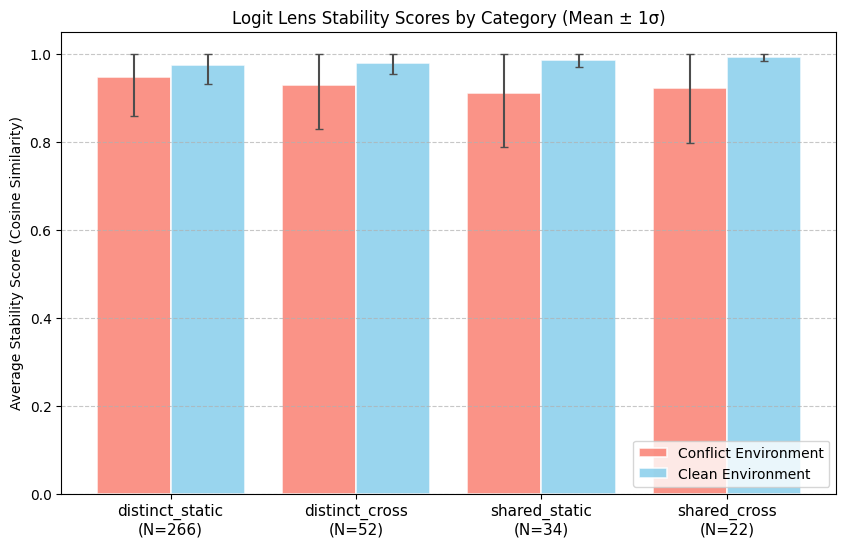

In [158]:
import numpy as np

# Plot stability scores
def plot_stability_scores(
    stability_conflict_scores: dict,
    stability_clean_scores: dict
) -> None:
    categories = list(stability_conflict_scores.keys())
    x = range(len(categories))

    conflict_means = [torch.tensor(stability_conflict_scores[cat]).mean().item() for cat in categories]
    clean_means = [torch.tensor(stability_clean_scores[cat]).mean().item() for cat in categories]
    conflict_stds = [torch.tensor(stability_conflict_scores[cat]).std().item() for cat in categories]
    clean_stds = [torch.tensor(stability_clean_scores[cat]).std().item() for cat in categories]

    # Ensure error bars do not exceed [0, 1]
    conflict_upper = np.minimum(np.array(conflict_means) + np.array(conflict_stds), 1.0) - np.array(conflict_means)
    clean_upper = np.minimum(np.array(clean_means) + np.array(clean_stds), 1.0) - np.array(clean_means)

    conflict_yerr = [conflict_stds, conflict_upper]
    clean_yerr = [clean_stds, clean_upper]

    counts = [len(stability_conflict_scores[cat]) for cat in categories]

    xtick_labels = [f"{cat}\n(N={n})" for cat, n in zip(categories, counts)]

    error_config = {'ecolor': '0.3', 'capsize': 3, 'elinewidth': 1.5}
    bar_config = {'alpha': 0.85, 'edgecolor': 'white', 'linewidth': 1.2, 'width': 0.4}

    plt.figure(figsize=(10, 6))
    plt.bar([i - 0.2 for i in x], conflict_means,
            label='Conflict Environment', color='salmon',
            yerr=conflict_yerr, error_kw=error_config, **bar_config)
    plt.bar([i + 0.2 for i in x], clean_means,
            label='Clean Environment', color='skyblue',
            yerr=clean_yerr, error_kw=error_config, **bar_config)

    plt.xticks(x, xtick_labels, fontsize=11)
    plt.ylabel('Average Stability Score (Cosine Similarity)')
    plt.title('Logit Lens Stability Scores by Category (Mean ± 1σ)')
    plt.legend(loc="lower right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1.05)
    
    plt.savefig("logit_lens/stability_scores_summary.png", dpi=300)
    print("Displaying ...")
    plt.show()

plot_stability_scores(
    stability_conflict_scores,
    stability_clean_scores
)

* 검증 내용 2. 레이어 별 갈등 양상이 유사할 것이다.

In [ ]:
import torch.nn.functional as F

def compute_layerwise_prob_mse(
    model,
    tokenizer,
    org_logit_lens_inputs: LogitLensInputs,
    prp_logit_lens_inputs: LogitLensInputs,
    target_word: str,
    counter_word: str,
    input_type: str
) -> torch.Tensor:
    """
    Compute layerwise probability MSE between original and paraphrased inputs.
    """
    org_output = analyze_logit_lens(
        model,
        tokenizer,
        org_logit_lens_inputs,
        target_word,
        counter_word,
        input_type
    )
    prp_output = analyze_logit_lens(
        model,
        tokenizer,
        prp_logit_lens_inputs,
        target_word,
        counter_word,
        input_type
    )

    # Compute similarity metrics

    # Target word probabilities
    vec_tgt_org = torch.tensor(org_output.probs_target)
    vec_tgt_prp = torch.tensor(prp_output.probs_target)

    # Counter word probabilities
    vec_cnt_org = torch.tensor(org_output.probs_counter)
    vec_cnt_prp = torch.tensor(prp_output.probs_counter)

    # MSE
    mse_tgt = torch.abs(vec_tgt_org - vec_tgt_prp)
    mse_cnt = torch.abs(vec_cnt_org - vec_cnt_prp)

    mse_score = (mse_tgt + mse_cnt) / 2.0
    return mse_score

In [160]:
prob_diff_conflict_scores = {category: [] for category in categories}
prob_diff_clean_scores = {category: [] for category in categories}

for category, inspection_list in merged_inspection_dict.items():
    for inspection_sample in tqdm(inspection_list, desc=f"Processing {category}"):
        # Unpack inputs
        sub_logit_lens_inputs = inspection_sample["sub_logit_lens_inputs"]
        prp_sub_logit_lens_inputs = inspection_sample["paraphrased_sub_logit_lens_inputs"]
        org_logit_lens_inputs = inspection_sample["org_logit_lens_inputs"]
        prp_org_logit_lens_inputs = inspection_sample["paraphrased_org_logit_lens_inputs"]
        target_word = inspection_sample["answer"][0]
        counter_word = inspection_sample["sub_answer"][0]

        # 1. Prob Difference in Conflict Environment
        prob_diff_conflict = compute_layerwise_prob_mse(
            model,
            tokenizer,
            org_logit_lens_inputs=sub_logit_lens_inputs,        # original situation (question A)
            prp_logit_lens_inputs=prp_sub_logit_lens_inputs,    # original situation (question B - Paraphrased)
            target_word=target_word,
            counter_word=counter_word,
            input_type="substituted"
        )

        # 2. Prob Difference in Clean Environment
        prob_diff_clean = compute_layerwise_prob_mse(
            model,
            tokenizer,
            org_logit_lens_inputs=org_logit_lens_inputs,      # original situation (question A)
            prp_logit_lens_inputs=prp_org_logit_lens_inputs, # original situation (question B - Paraphrased)
            target_word=target_word,
            counter_word=counter_word,
            input_type="original"
        )
        prob_diff_conflict_scores[category].append(prob_diff_conflict)
        prob_diff_clean_scores[category].append(prob_diff_clean)

for category in categories:
    print(f"Total samples in {category}: {len(prob_diff_conflict_scores[category])}")

Processing shared_cross: 100%|██████████| 22/22 [00:04<00:00,  5.05it/s]

Total samples in distinct_static: 266
Total samples in distinct_cross: 52
Total samples in shared_static: 34
Total samples in shared_cross: 22


In [161]:
for category in categories:
    conflict_res = prob_diff_conflict_scores[category]
    clean_res = prob_diff_clean_scores[category]

    # Stack tensors to compute mean and std
    conflict_stack = torch.stack(conflict_res)  # Shape: (num_samples, num_layers)
    clean_stack = torch.stack(clean_res)        # Shape: (num_samples, num_layers)

    prob_diff_conflict_scores[category] = conflict_stack
    prob_diff_clean_scores[category] = clean_stack

In [162]:
prob_diff_conflict_scores["distinct_cross"].shape

torch.Size([52, 33])

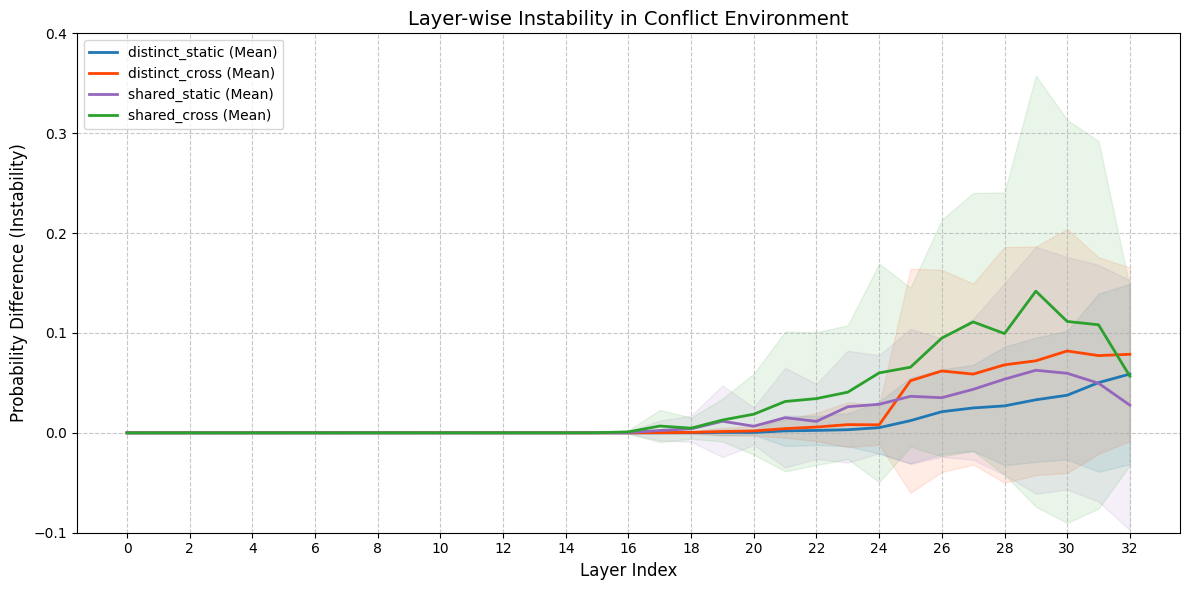

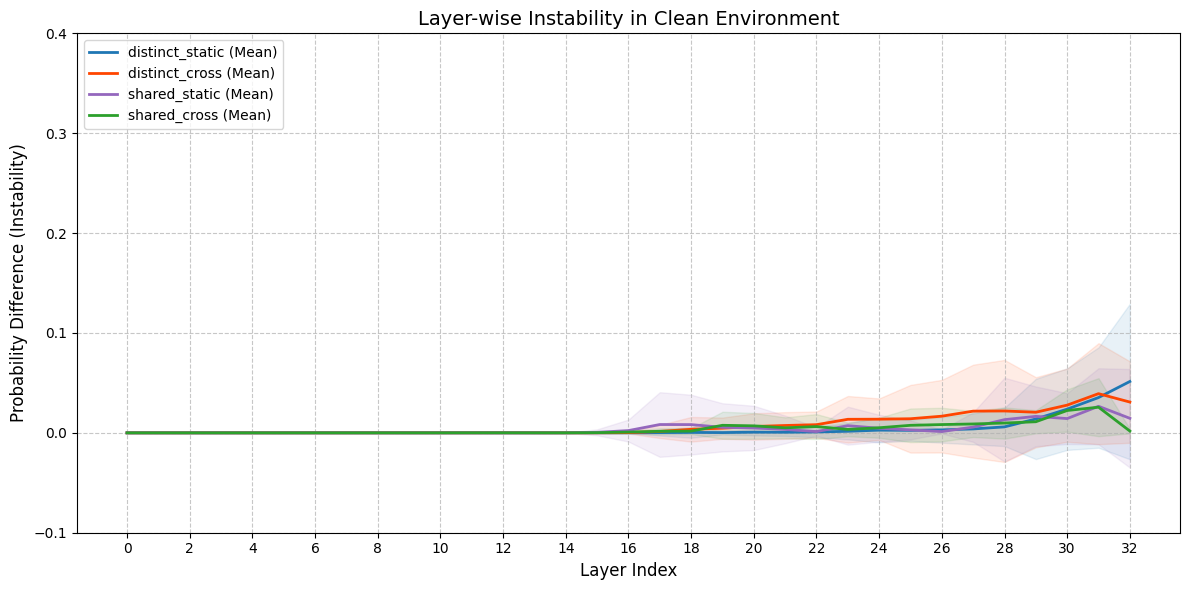

In [167]:
def plot_layerwise_instability(
    diff_tensors_dict: torch.Tensor,
    title: str = "Layer-wise Instability Comparison",
    plot_type: str = "conflict"
):
    colors = {
        'distinct_cross': '#FF4500',  
        'distinct_static': '#1f77b4', 
        'shared_cross': '#2ca02c',    
        'shared_static': '#9467bd'    
    }
    plt.figure(figsize=(12, 6))

    for i, (name, tensor) in enumerate(diff_tensors_dict.items()):
        # Move to CPU and convert to numpy
        if tensor.is_cuda:
            tensor = tensor.cpu()
        data = tensor.numpy()  # Shape: (N, 33)

        # Compute mean and std
        mean_curve = np.mean(data, axis=0) # Shape: (33,)
        std_curve = np.std(data, axis=0)   # Shape: (33,)
        layers = np.arange(len(mean_curve)) # 0 ~ 32

        color = colors.get(name, "black")

        # (1) Mean line
        plt.plot(layers, mean_curve, label=f'{name} (Mean)', color=color, linewidth=2)

        # (2) Std area
        plt.fill_between(
            layers, 
            mean_curve - std_curve, 
            mean_curve + std_curve, 
            color=color, alpha=0.1,
            label='_nolegend_'
        )

    # Styling
    plt.xlabel('Layer Index', fontsize=12)
    plt.ylabel('Probability Difference (Instability)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.xticks(np.arange(0, len(layers), step=2))
    plt.ylim(-0.1, 0.4)

    plt.tight_layout()
    plt.savefig(f"logit_lens/layerwise_instability_{plot_type}.png", dpi=300)
    plt.show()
    plt.close()

plot_layerwise_instability(prob_diff_conflict_scores, title="Layer-wise Instability in Conflict Environment", plot_type="conflict")
plot_layerwise_instability(prob_diff_clean_scores, title="Layer-wise Instability in Clean Environment", plot_type="clean")

### 2. Comprehensiveness

$\text{Comprehensiveness} = \frac{1}{N}\sum_{i=1}^{N}(P(y | x_i) - P(y | x_i^{k'}))$   - [Reference]

=>

$\text{Comprehensiveness} = \frac{1}{N}\sum_{i=1}^{N}(P_{final} (y | x_i) - max_k P(y | x_i))$   - [In Conflict Domain]


* $x_i^{k'}$: 기존 방법은 Top-K layer 제거 후 logit 평가
* 추출된 근거가 예측 결과에 얼마나 필수적인가를 평가하는 지표
* 그러나 트랜스포머는 레이어가 쌓인 구조이므로 이전 레이어의 제거는 다음 레이어의 예측에 치명적

* 따라서 **마지막 레이어의 확률 분포 변화 - 중간 레이어들**를 베이스라인과 비교하는 방식을 적용함

In [169]:
# Define intermediate layers
intermediate_layers = list(range(16, 32))   # Layers 16 to last - 1
intermediate_layers

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

In [198]:
import torch.nn.functional as F

def compute_comprehensiveness_gap(
    model,
    tokenizer,
    logit_lens_inputs: LogitLensInputs,
    target_word: str,
    counter_word: str,
    input_type: str,
    intermediate_layers: List[int]
) -> Dict[str, float]:
    """
    Compute the comprehensiveness gap

    Positive Value: Enhancement
    Negative Value: Suppression
    """
    output = analyze_logit_lens(
        model,
        tokenizer,
        logit_lens_inputs,
        target_word,
        counter_word,
        input_type
    )

    # Compute similarity metrics

    # Target word probabilities
    vec_tgt = torch.tensor(output.probs_target)

    # Counter word probabilities
    vec_cnt = torch.tensor(output.probs_counter)

    # Max probabilities in intermediate layers
    tgt_intermediate_max = torch.max(vec_tgt[intermediate_layers])
    cnt_intermediate_max = torch.max(vec_cnt[intermediate_layers])

    tgt_gap = vec_tgt[-1] - tgt_intermediate_max    # Final layer vs intermediate max
    cnt_gap = vec_cnt[-1] - cnt_intermediate_max    # Final layer vs intermediate max

    return {
        "tgt_gap": tgt_gap.item(),
        "cnt_gap": cnt_gap.item()
    }

In [199]:
merged_inspection_dict["distinct_static"][0].keys()

dict_keys(['idx', 'question', 'answer', 'sub_answer', 'org_logit_lens_inputs', 'sub_logit_lens_inputs', 'paraphrased_org_logit_lens_inputs', 'paraphrased_sub_logit_lens_inputs'])

In [200]:
conflict_comprehensiveness_gap_dict = {category: [] for category in categories}
clean_comprehensiveness_gap_dict = {category: [] for category in categories}

for category, inspection_list in merged_inspection_dict.items():
    for inspection_sample in tqdm(inspection_list, desc=f"Processing {category}"):
        # Unpack inputs
        sub_logit_lens_inputs = inspection_sample["sub_logit_lens_inputs"]
        org_logit_lens_inputs = inspection_sample["org_logit_lens_inputs"]
        target_word = inspection_sample["answer"][0]
        counter_word = inspection_sample["sub_answer"][0]

        # 1. Comprehensiveness Gap in Conflict Environment
        conflict_comprehensiveness_gap = compute_comprehensiveness_gap(
            model,
            tokenizer,
            logit_lens_inputs=sub_logit_lens_inputs,
            target_word=target_word,
            counter_word=counter_word,
            input_type="substituted",
            intermediate_layers=intermediate_layers
        )

        # 2. Comprehensiveness Gap in Clean Environment
        clean_comprehensiveness_gap = compute_comprehensiveness_gap(
            model,
            tokenizer,
            logit_lens_inputs=org_logit_lens_inputs,
            target_word=target_word,
            counter_word=counter_word,
            input_type="original",
            intermediate_layers=intermediate_layers
        )
        conflict_comprehensiveness_gap_dict[category].append(conflict_comprehensiveness_gap)
        clean_comprehensiveness_gap_dict[category].append(clean_comprehensiveness_gap)

for category in categories:
    print(f"Total samples in {category}: {len(conflict_comprehensiveness_gap_dict[category])}")

Processing shared_cross: 100%|██████████| 22/22 [00:02<00:00, 10.09it/s]

Total samples in distinct_static: 266
Total samples in distinct_cross: 52
Total samples in shared_static: 34
Total samples in shared_cross: 22


Displaying ...


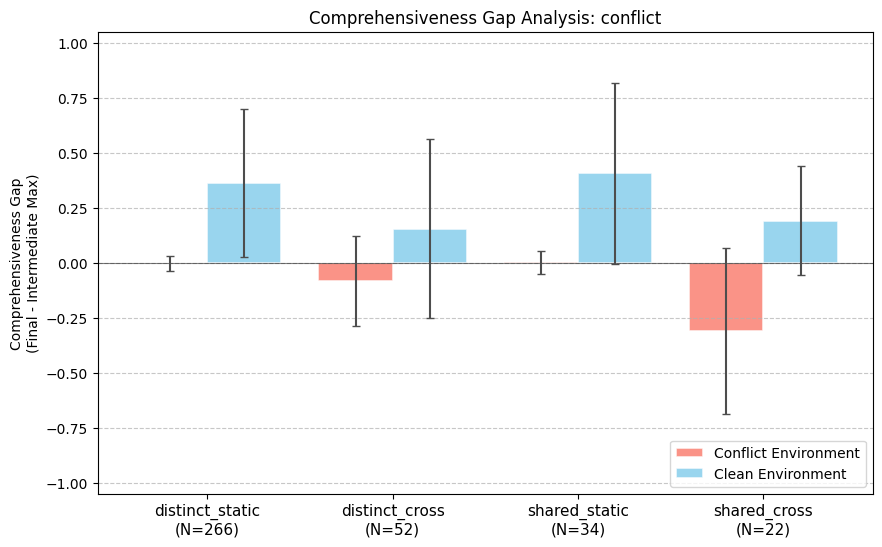

Displaying ...


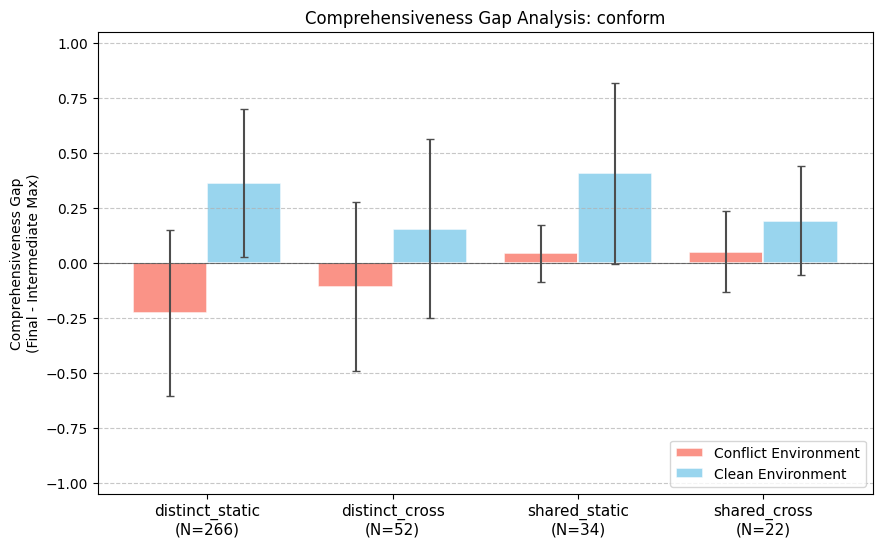

In [201]:
def plot_comprehensiveness_gap(
    conflict_gap_dict: Dict[str, List[Dict[str, float]]],
    clean_gap_dict: Dict[str, List[Dict[str, float]]],
    conform_type: str = "conflict"
):
    categories = list(conflict_gap_dict.keys())
    x = range(len(categories))

    inspect_key = "tgt_gap" if conform_type == "conflict" else "cnt_gap"
    
    conflict_gaps_inspect_dict = {cat: [item[inspect_key] for item in conflict_list]
                          for cat, conflict_list in conflict_gap_dict.items()}
    clean_gaps_inspect_dict = {cat: [item["tgt_gap"] for item in clean_list]
                       for cat, clean_list in clean_gap_dict.items()}
    
    conflict_means = [torch.tensor(conflict_gaps_inspect_dict[cat]).mean().item() for cat in categories]
    clean_means = [torch.tensor(clean_gaps_inspect_dict[cat]).mean().item() for cat in categories]
    conflict_stds = [torch.tensor(conflict_gaps_inspect_dict[cat]).std().item() for cat in categories]
    clean_stds = [torch.tensor(clean_gaps_inspect_dict[cat]).std().item() for cat in categories]

    # Ensure error bars do not exceed [-1, 1]
    conflict_upper = np.minimum(np.array(conflict_means) + np.array(conflict_stds), 1.0) - np.array(conflict_means)
    clean_upper = np.minimum(np.array(clean_means) + np.array(clean_stds), 1.0) - np.array(clean_means)
    conflict_lower = np.array(conflict_means) - np.maximum(np.array(conflict_means) - np.array(conflict_stds), -1.0)
    clean_lower = np.array(clean_means) - np.maximum(np.array(clean_means) - np.array(clean_stds), -1.0)
    
    conflict_yerr = [conflict_lower, conflict_upper]
    clean_yerr = [clean_lower, clean_upper]

    counts = [len(conflict_gap_dict[cat]) for cat in categories]
    
    xtick_labels = [f"{cat}\n(N={n})" for cat, n in zip(categories, counts)]

    error_config = {'ecolor': '0.3', 'capsize': 3, 'elinewidth': 1.5}
    bar_config = {'alpha': 0.85, 'edgecolor': 'white', 'linewidth': 1.2, 'width': 0.4}

    plt.figure(figsize=(10, 6))

    plt.axhline(0, color='black', linewidth=0.8, linestyle='-', alpha=0.5)

    plt.bar([i - 0.2 for i in x], conflict_means,
            label='Conflict Environment', color='salmon',
            yerr=conflict_yerr, error_kw=error_config, **bar_config)
    plt.bar([i + 0.2 for i in x], clean_means,
            label='Clean Environment', color='skyblue',
            yerr=clean_yerr, error_kw=error_config, **bar_config)

    plt.xticks(x, xtick_labels, fontsize=11)
    plt.ylabel('Comprehensiveness Gap\n(Final - Intermediate Max)')
    plt.title(f'Comprehensiveness Gap Analysis: {conform_type}')
    plt.legend(loc="lower right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(-1.05, 1.05)

    plt.savefig(f"logit_lens/comprehensiveness_gap_{conform_type}.png", dpi=300)
    print("Displaying ...")
    plt.show()
    plt.close()

plot_comprehensiveness_gap(
    conflict_comprehensiveness_gap_dict,
    clean_comprehensiveness_gap_dict,
    conform_type="conflict"
)
plot_comprehensiveness_gap(
    conflict_comprehensiveness_gap_dict,
    clean_comprehensiveness_gap_dict,
    conform_type="conform"
)

In [204]:
print("Comprehensiveness Gap Summary Statistics:\n")
all_summary = {}

for category in categories:
    conflict_stats_tgt = summary_statistics(
        [item["tgt_gap"] for item in conflict_comprehensiveness_gap_dict[category]]
    )
    conflict_stats_cnt = summary_statistics(
        [item["cnt_gap"] for item in conflict_comprehensiveness_gap_dict[category]]
    )
    clean_stats = summary_statistics(
        [item["tgt_gap"] for item in clean_comprehensiveness_gap_dict[category]]
    )
    print(f"Category: {category}")
    print(f"  Conflict Environment Tgt - Mean: {conflict_stats_tgt.mean:.4f}, Std: {conflict_stats_tgt.std:.4f}, "
          f"Min: {conflict_stats_tgt.min:.4f}, Max: {conflict_stats_tgt.max:.4f}")
    print(f"  Conflict Environment Cnt - Mean: {conflict_stats_cnt.mean:.4f}, Std: {conflict_stats_cnt.std:.4f}, "
          f"Min: {conflict_stats_cnt.min:.4f}, Max: {conflict_stats_cnt.max:.4f}")
    print(f"  Clean Environment    - Mean: {clean_stats.mean:.4f}, Std: {clean_stats.std:.4f}, "
          f"Min: {clean_stats.min:.4f}, Max: {clean_stats.max:.4f}\n")
    all_summary[category] = {
        "conflict_tgt": conflict_stats_tgt,
        "conflict_cnt": conflict_stats_cnt,
        "clean_tgt": clean_stats
    }

Comprehensiveness Gap Summary Statistics:

Category: distinct_static
  Conflict Environment Tgt - Mean: -0.0021, Std: 0.0342, Min: -0.4961, Max: 0.1628
  Conflict Environment Cnt - Mean: -0.2300, Std: 0.3763, Min: -0.9714, Max: 0.8120
  Clean Environment    - Mean: 0.3613, Std: 0.3373, Min: -0.3926, Max: 0.9788

Category: distinct_cross
  Conflict Environment Tgt - Mean: -0.0838, Std: 0.2031, Min: -0.8130, Max: 0.2036
  Conflict Environment Cnt - Mean: -0.1088, Std: 0.3842, Min: -0.8643, Max: 0.9019
  Clean Environment    - Mean: 0.1549, Std: 0.4069, Min: -0.4219, Max: 0.9788

Category: shared_static
  Conflict Environment Tgt - Mean: 0.0018, Std: 0.0531, Min: -0.1299, Max: 0.2471
  Conflict Environment Cnt - Mean: 0.0419, Std: 0.1297, Min: -0.0625, Max: 0.6152
  Clean Environment    - Mean: 0.4057, Std: 0.4112, Min: -0.1367, Max: 0.9955

Category: shared_cross
  Conflict Environment Tgt - Mean: -0.3111, Std: 0.3769, Min: -0.9101, Max: 0.2031
  Conflict Environment Cnt - Mean: 0.0498, 

In [205]:
import json
from dataclasses import asdict

def format_stats(stats: SummaryStatistics):
    """SummaryStatistics 객체를 .4f 포맷의 딕셔너리로 변환"""
    return {
        k: round(v, 4) for k, v in asdict(stats).items()
    }

# Save the comprehensiveness gap scores
with open("logit_lens/comprehensiveness_gap_scores.json", "w") as f:
    json.dump({
        "summary": {
            category: {
                "conflict_tgt": format_stats(stats["conflict_tgt"]),
                "conflict_cnt": format_stats(stats["conflict_cnt"]),
                "clean_tgt": format_stats(stats["clean_tgt"])
            } for category, stats in all_summary.items()
        }
    }, f, indent=4)